## 회고

#### Point 1) `padding='valid' / 'same'`이 만드는 결과
- 밑에 `conv_block()`함수를 보면 위와 같이 되어 있는데, 이해가지 않는 부분이 있다.
```python
if strides == (2, 2):
    x = tf.keras.layers.ZeroPadding2D(padding=((1, 1), (1, 1)), name='conv_pad_%d' % block_id)(inputs)
    x = tf.keras.layers.Conv2D(filters, kernel,
                                padding='valid',
                                use_bias=False,
                                strides=strides,
                                name='conv_%d' % block_id)(x)
else:
    x = tf.keras.layers.Conv2D(filters, kernel,
                                padding='same',
                                use_bias=False,
                                strides=strides,
                                name='conv_%d' % block_id)(inputs)
```

- `strides = (2, 2)`의 경우 feature map 사이즈를 **거의** 반으로 줄이겠다는 거로 해석이 되는데, `ZeroPadding2D`를 붙이고 `padding='valid'`으로 하고 있다.
- 이럴거면 그냥 `padding='same'`으로 하는 것과 같지 않을까? 하는 궁금증에 한 번 시도해봤다.
- 노트북 내에서도 결과에 대해 써놓았지만, 결론적으로 `input_shape`에 따라 둘 사이에 차이가 있을 수도 있고 없을 수도 있는 거로 확인했다.
- 실험해본 결과, `kernel_size=(3, 3)`, `strides=(2, 2)`의 형태라면...
  - input 이미지의 H, W가 **짝수일 경우** 두 방법 사이에 패딩하는 부분의 위치가 달라져서 차이가 생기고(이는 padding=`valid`의 효과)
  - 만약 **홀수일 경우** 이미지 좌우상하에 패딩해줘야 하기에 패딩 위치 및 구조로 인해 생기는 값 차이는 오지 않는 것으로 파악했다.
- 물론 어찌 보면 **이미지의 어느 위치를 아주 살짝 distort(?)해갈 것이냐**의 사소한 문제이기에
이를 코드 짠 분이 의도하고 했는지는 모르겠으나, 결론적으로 해당 방법은 `padding='same'`과 다르게 쓰일 수 있었다.

#### Point 2) 여러 개 스티커 붙이기 시도
- 우선적으로 모델의 detection 성능이 좋아야 한다.(이번 모델은 주어진 pre-trained 가중치나 오랜 시간 에포크를 돌린 가중치나 만족할 만한 detection 능력은 보여주지 못했다.)
- 그 다음 우선순위는 얼굴 크기 & 각도에 따른 스티커 크기 & 각도 변경인데, 이번 프로젝트에선 그냥 **크기 변경**까지만 구현해봤다.
- 아래는 스티커 붙이기 구현 과정에서 맞닥뜨린 문제 및 해결 과정을 적어봤다.
  1. 함수 짜는 게 일단 어려웠다
    - 검출된 얼굴 크기에 따라 같은 비율로 스티커 크기도 변해야 하는데, 어떻게 할 수 있을까 고민되었다.
    - 해결법은 노트북 상에도 적어놨지만, 검출된 bbox의 좌표 및 크기를 이용해 스티커의 좌표 및 크기를 맞춰봤고, 나름 잘 된 것 같다.
  2. 4채널 RGBA를 합쳐주는 것에서 오류(?)
    - 원본 이미지 + 스티커 이미지를 합쳐줘야 하는데, `png` 파일인 스티커 이미지는 4채널이어서 오류가 떴었다.
    - 물론 스티커 이미지를 3채널로 줄여주던가, 원본 이미지를 4채널로 늘려주던가 쉽게 할 수 있지만, 이 오류에서 어려웠던 점은 **많은 과정이 담긴 함수에서 어떤 부분에서 오류가 난 건지 찾아내는 것**이었다.
    - 결과적으로 단계마다 print로 output들을 다 찍어봄으로서 해결할 수 있었다.
  3. 이미지 값이 `255.4`등으로 float 형태로 `1`을 넘는 범위로 되어 있었음
     - 해당 오류는 `plt.imshow()`로 이미지 출력 시 `0.0 ~ 1.0 사이의 값 혹은 0 ~ 255 정수의 값이 아니어서 그것에 맞췄다`라는 오류가 떠서 알게 됐고, 사실 어느 부분에서 저런 오류가 발생하는지 몰랐다(추정한 image_array 값들은 `0.0 ~ 1.0 사이의 float` 혹은 `0 ~ 255` 사이의 정수값이었다.)
    - 그런데 이 오류의 포인트는 output들의 shape을 봐서는 모른다는 사실이다.
    - 결론적으로 output들의 `min()`, `max()` 값을 찍어봐서 알게 되었는데, 이런 경우도 있구나라는 것을 경험할 수 있었다.
    - 참고로, 이렇게 image_array 값이 이상해진 이유는 `0.0 ~ 1.0` 사이로 normalise하고 또 다른 과정을 거친 image_array에 ` * 255`를 하니까 생기게 된 것으로 추정한다.
    - 해결 방법은 그냥 `.astype(np.uint8)`으로 해결했다.
 4. 하얀색 부분 masking 하기
   - 하얀 배경 부분을 masking한다고 ` == 255`조건을 걸어서 했는데 하얀색 부분이 지워지지 않았다.
   - 확인해보니 하얀색이 `245`값으로 되어 있었다.
   - 그래서 masking 조건을 ` >= 245`로 하니까 하얀 배경은 전부 사라졌는데 노란색, 빨간색들 중 진한 색깔은 물 빠지듯 투명하게 되어버렸다.(예 : 하트 중간 부분)
   - 이 부분은 일단 제일 쉽게 이미지 자체를 바꾸거나, 혹은 245 중 하얀색 부분만 찾아내서 255로 바꿔주던가 해야 할 것 같은데, 그래도 많은 고민을 거친 후였기에 이 상태에 만족하고 냅두기로 했다.
 5. 여러 object가 검출되었을 경우 전체 다 스티커 붙이는 방법
   - 스티커를 붙일 때 object 전부를 한꺼번에 붙일 수 없는 것 같았다(코드 구현 가능할까...?).
   - 그리고 스티커를 하나씩 붙여준다면, 우선순위가 필요해보였다.
   - 왜냐하면, 예를 들어 검출된 object가 서로 밀접하게 붙어 있을 수도 있는데, 이 경우 스티커가 object bbox 밖으로 많이 뻗어나가는 거라면 옆에 있는 원본 이미지의 object에도 영향을 줄 수 있기 때문이다.
   - 그래서 한 object의 스티커를 붙인 경우 그것을 다른 object의 스티커가 덮어써야 한다면, 이 경우 어떤 object가 덮어씌움 당하고, 어떤 object가 위로 올라오느냐를 결정해서 해당 순서에 맞게 코드를 짜줘야 한다.
   - 약간 복잡하다 느껴졌었지만 곰곰히 생각해봤을 때 bbox 넓이가 큰 물체를 제일 나중에 스티커 붙여주는 게 확률상 viewpoint 입장에서 **제일 앞 쪽에** 위치는 object일 가능성이 있기 때문에 bbox 넓이가 작은 것들을 먼저 스티커 붙여주면 될 것 같았다. 
   - 그래서 bbox 좌표 값을 통해 면적을 구하고, 면적의 오름차순으로 정리하는 것을 코드로 구현해서 스티커 붙이기의 우선순위를 정했다.

#### Point 3) `model.load_weights()`의 리턴 값...
- 맨 처음 pre-trained된 모델의 weights을 갖고 오기 위해 `.load_weights()`의 사용법을 찾아봤고, 텐서플로우 홈페이지에서 아래와 같은 사용법이 있다는 것을 발견했다.

```python
sequential_model.save_weights("ckpt")
load_status = sequential_model.load_weights("ckpt")

# `assert_consumed` can be used as validation that all variable values have been
# restored from the checkpoint. See `tf.train.Checkpoint.restore` for other
# methods in the Status object.
load_status.assert_consumed()
```
- 하지만, `load_status`값이 계속해서 `None`으로 나왔고, 이 때문에 `load_status.assert_consumed()`에서 오류가 났다.
- 그래서 `load_weights(by_name=True, skip_mismatch=True)`와 같이 파라미터 변경으로도 시도해봤지만, 무언가 제대로된 실행 값이 나오는 것 같지 않았고 궁극적으로 찾아낸 해답은 사실 **`load_weights()`는 return하는 게 없다는 것**이었다.
- 해당 내용을 확인 후 가중치가 load된 것을 확인하기 위해서 그냥 inference를 수행했고, 이를 통해 모델에 가중치가 제대로 load되었음을 확인했다.

## 프로젝트 : 스티커를 붙여주자

#### 배경
- 이미지 내 작은 물체 인식의 필요성과 해결 방법을 이론적으로 접근해봤다.
- SSD 모델의 구현 코드를 실습해봤다.
- 이를 통해 이미지 내 사람 얼굴을 검출하고, 검출된 bbox를 이용해 스티커를 붙여보는 자동화 코드를 완성해보자.

### 1) 라이브러리 버전 확인
---

In [1]:
import tensorflow as tf
import numpy as np
import cv2
import os
import time
import tqdm
import math
from itertools import product
import matplotlib.pyplot as plt

print(tf.__version__)
print(np.__version__)
print(cv2.__version__)

2.8.0
1.21.6
4.1.2


### 2) 데이터 전처리 (1) - 경로 생성 및 전처리 함수 선언
---
- 작은 얼굴 인식 task 관련해서는 WIDER FACE 데이터셋을 사용한다.
- http://shuoyang1213.me/WIDERFACE/index.html

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
ROOT_PATH = '/content/drive/My Drive/Aiffel/GD_14'
CHECKPOINT_PATH = ROOT_PATH + '/raw_checkpoints'

TRAIN_PATH = ROOT_PATH + '/WIDER_train/images'
TEST_PATH = ROOT_PATH + '/WIDER_test/images'
VAL_PATH = ROOT_PATH + '/WIDER_val/images'

STICKER_PATH = ROOT_PATH + '/sticker.png'

TRAIN_TXT_PATH = ROOT_PATH + '/wider_face_split/wider_face_train_bbx_gt.txt'
VAL_TXT_PATH = ROOT_PATH + '/wider_face_split/wider_face_val_bbx_gt.txt'

#### 데이터 전처리 함수 생성

##### 데이터에서 bbox 데이터로 parsing해주는 함수

In [4]:
def parse_box(data):
    x0 = int(data[0])
    y0 = int(data[1])
    w = int(data[2])
    h = int(data[3])
    return x0, y0, w, h

##### WIDER FACE 데이터 형식에 맞게 데이터 불러와서 필요한 데이터들 뽑아내는 함수

In [5]:
def parse_widerface(file):
    infos = []
    with open(file) as fp:
        line = fp.readline()                   # 첫번째 라인이 있으면 그건 파|일 이름?
        while line:                            # 있을 경우
            n_object = int(fp.readline())      # 그 다음 라인은 박스 개수
            boxes = []
            for i in range(n_object):          # 박스 개수만큼 for loop
                box = fp.readline().split(' ') # 그 다음 라인부터는 박스들 좌표
                x0, y0, w, h = parse_box(box)
                if (w == 0) or (h == 0):       # w, h가 없는 건 건너뛰기
                    continue
                boxes.append([x0, y0, w, h])
            if n_object == 0:                  # 박스 개수가 0이면...?
                box = fp.readline().split(' ')
                x0, y0, w, h = parse_box(box)
                boxes.append([x0, y0, w, h])
            infos.append((line.strip(), boxes))
            line = fp.readline()
    return infos

##### 데이터에서 이미지 경로 받고, 해당 경로를 읽어들여서 이미지 어레이로 decode하는 함수

In [6]:
def process_image(image_file):
    image_string = tf.io.read_file(image_file)
    try:
        image_data = tf.io.decode_jpeg(image_string, channels=3)
        return 0, image_string, image_data                           # 데이터가 정상적이면 0이랑 반환...?
    except tf.errors.InvalidArgumentError:
        return 1, image_string, None

##### `xywh` 형식으로 있던 데이터를 PASCAL VOC 데이터셋 형식으로 바꿔주기
- 여기는 아래의 정보들이 담긴 형식이다.
- `class`(object마다 1의 length가 늘어난다.
- `x_min, y_min, x_max, y_max` : x1, x2 코너의 좌표들
- `difficult` : object가 detect 하기 어려우면 1, 아니면 0을 담는다.

In [7]:
def xywh_to_voc(file_name, boxes, image_data):
    shape = image_data.shape
    image_info = {}
    image_info['filename'] = file_name
    image_info['width'] = shape[1]
    image_info['height'] = shape[0]
    image_info['depth'] = 3

    difficult = []
    classes = []
    xmin, ymin, xmax, ymax = [], [], [], []

    for box in boxes:
        classes.append(1)
        difficult.append(0)
        xmin.append(box[0])
        ymin.append(box[1])
        xmax.append(box[0] + box[2])
        ymax.append(box[1] + box[3])
    image_info['class'] = classes
    image_info['xmin'] = xmin
    image_info['ymin'] = ymin
    image_info['xmax'] = xmax
    image_info['ymax'] = ymax
    image_info['difficult'] = difficult

    return image_info

##### 데이터 읽어오는 것 확인

In [8]:
for i, info in enumerate(parse_widerface(TRAIN_TXT_PATH)):
    print('--------------------')
    image_file = os.path.join(TRAIN_PATH, info[0]) # 여기서 info[0]은 파일 경로가 담겨있다.
    _, image_string, image_data = process_image(image_file)
    boxes = xywh_to_voc(image_file, info[1], image_data)  # 여기서 info[1]은 박스가 담겨있다.(만약 박스가 여러개이면 여러 개가 다 2차원 리스트로 담겨 있다.)
    print(boxes)
    if i > 3:
        break

--------------------
{'filename': '/content/drive/My Drive/Aiffel/GD_14/WIDER_train/images/0--Parade/0_Parade_marchingband_1_849.jpg', 'width': 1024, 'height': 1385, 'depth': 3, 'class': [1], 'xmin': [449], 'ymin': [330], 'xmax': [571], 'ymax': [479], 'difficult': [0]}
--------------------
{'filename': '/content/drive/My Drive/Aiffel/GD_14/WIDER_train/images/0--Parade/0_Parade_Parade_0_904.jpg', 'width': 1024, 'height': 1432, 'depth': 3, 'class': [1], 'xmin': [361], 'ymin': [98], 'xmax': [624], 'ymax': [437], 'difficult': [0]}
--------------------
{'filename': '/content/drive/My Drive/Aiffel/GD_14/WIDER_train/images/0--Parade/0_Parade_marchingband_1_799.jpg', 'width': 1024, 'height': 768, 'depth': 3, 'class': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'xmin': [78, 78, 113, 134, 163, 201, 182, 245, 304, 328, 389, 406, 436, 522, 643, 653, 793, 535, 29, 3, 20], 'ymin': [221, 238, 212, 260, 250, 218, 266, 279, 265, 295, 281, 293, 290, 328, 320, 224, 337, 311, 220, 232

### 3) 데이터 전처리 (2) - TFRecord 생성
--- 
- parallel I/O 수행을 통해 I/O 측면에서 효율적이고, storage도 덜 차지하는 이점이 있다고 한다.
- TFRecord는 `tf.train.Example`이란 데이터들을 갖고 있다고 보면 되고, 그 데이터들의 특징(?)을 나타내는 건 `tf.train.Feature`라는 클래스를 통해 구성 가능하다.

In [9]:
def make_example(image_string, image_infos):
    for info in image_infos:
        filename = info['filename']
        width = info['width']
        height = info['height']
        depth = info['depth']
        classes = info['class']
        xmin = info['xmin']
        ymin = info['ymin']
        xmax = info['xmax']
        ymax = info['ymax']

    if isinstance(image_string, type(tf.constant(0))):
        encoded_image = [image_string.numpy()]
    else:
        encoded_image = [image_string]

    base_name = [tf.compat.as_bytes(os.path.basename(filename))]
    
    example = tf.train.Example(features=tf.train.Features(feature={
        'filename':tf.train.Feature(bytes_list=tf.train.BytesList(value=base_name)),
        'height':tf.train.Feature(int64_list=tf.train.Int64List(value=[height])),
        'width':tf.train.Feature(int64_list=tf.train.Int64List(value=[width])),
        'classes':tf.train.Feature(int64_list=tf.train.Int64List(value=classes)),
        'x_mins':tf.train.Feature(float_list=tf.train.FloatList(value=xmin)),
        'y_mins':tf.train.Feature(float_list=tf.train.FloatList(value=ymin)),
        'x_maxes':tf.train.Feature(float_list=tf.train.FloatList(value=xmax)),
        'y_maxes':tf.train.Feature(float_list=tf.train.FloatList(value=ymax)),
        'image_raw':tf.train.Feature(bytes_list=tf.train.BytesList(value=encoded_image))
    }))
    
    return example

In [10]:
TRAIN_TFRECORD_PATH = ROOT_PATH + 'train_mask.tfrecord'
VAL_TFRECORD_PATH = ROOT_PATH + 'val_mask.tfrecord'

In [11]:
# for split in ['train', 'val']:            # train, val 각각 경로가 달라서 이렇게 나눠서 진행
#     if split == 'train':
#         output_file = TRAIN_TFRECORD_PATH 
#         TXT_PATH = TRAIN_TXT_PATH
#         file_path = TRAIN_PATH
#     else:
#         output_file = VAL_TFRECORD_PATH
#         TXT_PATH = VAL_TXT_PATH
#         file_path = VAL_PATH

#     with tf.io.TFRecordWriter(output_file) as writer:        # TFRecord 파일을 만들 때는 tf.io.TFRecordWriter 클래스를 사용
#         for info in tqdm.tqdm(parse_widerface(TXT_PATH)):    # WIDER FACE 데이터 포맷에 맞는 parsing 함수. TXT_PATH는 원본 데이터 경로
#             image_file = os.path.join(file_path, info[0])    # 이미지별 최종 경로 만들기
#             error, image_string, image_data = process_image(image_file)   # 이미지를 decode한 결과 갖기
#             boxes = xywh_to_voc(image_file, info[1], image_data)          # decode된 이미지와 원본 데이터에서 뽑아낸 정보를 갖고 PASCAL VOC 데이터셋 형태로 변환
#                                                                           # 여기서 boxes 외의 정보도 있지만, boxes 정보가 중요하기 때문에 boxes라고 표현한 듯
#             if not error:
#                 tf_example = make_example(image_string, [boxes])          # 최종적으로 TFRecord에 담길 tf.train.Example 객체로 만들기
#                 writer.write(tf_example.SerializeToString())              # Serializing

In [12]:
# # 만들어졌는지 확인
# !ls /content/drive/My Drive/Aiffel/GD_14

### 4) 모델 구현하기 (1) - default box 생성
---
- SSD 모델을 만들 건데, SSD의 경우 `Anchor box`과 같이 고정된 크기가 설정된 여러 개의 후보 bbox들을 미리 만들어 놓는다.
- SSD가 다른 점은 FPN처럼 여러 개의 feature map에 대해서 default box를 만든다는 것

#### 전역 변수 생성

In [13]:
DATASET_LEN = 12880
BATCH_SIZE = 32
IMAGE_WIDTH = 320
IMAGE_HEIGHT = 256
IMAGE_LABELS = ['background', 'face']

BOX_MIN_SIZES = [[10, 16, 24], [32, 48], [64, 96], [128, 192, 256]]
BOX_STEPS = [8, 16, 32, 64]

In [14]:
image_sizes = (IMAGE_HEIGHT, IMAGE_WIDTH)
min_sizes = BOX_MIN_SIZES
steps= BOX_STEPS

feature_maps = [
    [math.ceil(image_sizes[0] / step), math.ceil(image_sizes[1] / step)] # 여기서 step으로 나누는데 이는 receptive_field에 대한 배수를 나타내는 것 같다.
    for step in steps                                                    # 즉, feature map이 작아지면서 반대로 원래 이미지에 대한 receptive_field는 몇 배씩 늘어날 것이다. 그것을 step으로 나타낸 듯
]

feature_maps

[[32, 40], [16, 20], [8, 10], [4, 5]]

> **note**:
> - `default box`의 크기와 연계된 총 4개 사이즈의 `feature map` 크기를 미리 설정해놓는다.
> - 이 `feature map`의 크기들도 사용하려는 input image shape과 연계되어 있으며, 모델의 깊에 따라 conv layer를 거친 후 각각 몇 배 작아지는지 미리 계산된 값을 사용해서 만든다.

#### default box 생성

#### 어떻게 만드는지 대략적으로 확인

> **note**:
> - 아래에서 확인한 내용을 여기에 정리해보자면,
> - `s_kw`는 feature map 사이즈의 **넓이**로 정해놓은 값을 실제 이미지 사이즈의 넓이로 나눠줌으로서 실제에 대한 feature map 넓이 비율을 나타내고,
> - `s_ky`는 같은 방법으로 실제에 대한 feature map별 높이 비율을 나타낸다.
> - 또한, `cx`, `cy`의 경우, `i`, `j`로 대변되는 feature map 내 세로, 가로 픽셀의 개수, 즉 1픽셀당 위치값으로 볼 수 있는 것에 0.5씩 더해줌으로서 센터 좌표를 찾으려는 것이고, 여기에 `steps[k]`를 이미지 사이즈(넓이, 높이 각각)로 나눈 값을 곱함으로서 **실제 이미지에서 해당 `cx`, `cy`가 있게 될 위치를 각 feature map의 크기에 대한 비율로 나타내는 값**으로 판단된다.
> - 그래서 어떤 값이든 실제 이미지 크기에 대한 비율이어서 `0 ~ 1` 사이의 값을 가지는 것 같다.

In [15]:
boxes = []
for k, f in enumerate(feature_maps):
    for i, j in product(range(f[0]), range(f[1])):  # feature map 크기에 따른 픽셀들 각각에 만들어 주는 듯 i가 H, j가 W
        for min_size in min_sizes[k]:               # min_size[k]는 feature map 크기에 해당하는 min_size인듯
            s_kx = min_size / image_sizes[1]
            print(f"min_size : {min_size}, image_sizes[1] : {image_sizes[1]}, s_kw : {s_kx} <==== 1")
            s_ky = min_size / image_sizes[0]
            print(f"min_size : {min_size}, image_sizes[0] : {image_sizes[0]}, s_ky : {s_ky} <==== 2")
            cx = (j + 0.5) * steps[k] / image_sizes[1]
            print(f"j+0.5 : {j+0.5}, steps[k] : {steps[k]}, image_sizes[1] : {image_sizes[1]}, cx = {cx} <====3")
            cy = (i + 0.5) * steps[k] / image_sizes[0]
            print(f"i+0.5 : {i+0.5}, steps[k] : {steps[k]}, image_sizes[0] : {image_sizes[0]}, cy = {cy} <====4")
            boxes += [cx, cy, s_kx, s_ky]
            print("\n\n")
        if j == 2:
            break

len(boxes)

min_size : 10, image_sizes[1] : 320, s_kw : 0.03125 <==== 1
min_size : 10, image_sizes[0] : 256, s_ky : 0.0390625 <==== 2
j+0.5 : 0.5, steps[k] : 8, image_sizes[1] : 320, cx = 0.0125 <====3
i+0.5 : 0.5, steps[k] : 8, image_sizes[0] : 256, cy = 0.015625 <====4



min_size : 16, image_sizes[1] : 320, s_kw : 0.05 <==== 1
min_size : 16, image_sizes[0] : 256, s_ky : 0.0625 <==== 2
j+0.5 : 0.5, steps[k] : 8, image_sizes[1] : 320, cx = 0.0125 <====3
i+0.5 : 0.5, steps[k] : 8, image_sizes[0] : 256, cy = 0.015625 <====4



min_size : 24, image_sizes[1] : 320, s_kw : 0.075 <==== 1
min_size : 24, image_sizes[0] : 256, s_ky : 0.09375 <==== 2
j+0.5 : 0.5, steps[k] : 8, image_sizes[1] : 320, cx = 0.0125 <====3
i+0.5 : 0.5, steps[k] : 8, image_sizes[0] : 256, cy = 0.015625 <====4



min_size : 10, image_sizes[1] : 320, s_kw : 0.03125 <==== 1
min_size : 10, image_sizes[0] : 256, s_ky : 0.0390625 <==== 2
j+0.5 : 1.5, steps[k] : 8, image_sizes[1] : 320, cx = 0.0375 <====3
i+0.5 : 0.5, steps[k] : 8, imag

120

#### default box 다시 생성해보기

In [16]:
boxes = []
for k, f in enumerate(feature_maps):
    for i, j in product(range(f[0]), range(f[1])):
        for min_size in min_sizes[k]:
            s_kx = min_size / image_sizes[1]
            s_ky = min_size / image_sizes[0]
            cx = (j + 0.5) * steps[k] / image_sizes[1]
            cy = (i + 0.5) * steps[k] / image_sizes[0]
            boxes += [cx, cy, s_kx, s_ky]

len(boxes)

18800

In [17]:
# 확인
boxes[:20]

[0.0125,
 0.015625,
 0.03125,
 0.0390625,
 0.0125,
 0.015625,
 0.05,
 0.0625,
 0.0125,
 0.015625,
 0.075,
 0.09375,
 0.0375,
 0.015625,
 0.03125,
 0.0390625,
 0.0375,
 0.015625,
 0.05,
 0.0625]

In [18]:
# 4개씩 묶어서 행렬 모양으로 만들어주기
pretty_boxes = np.asarray(boxes).reshape([-1, 4])
print(pretty_boxes.shape)
print(pretty_boxes)

(4700, 4)
[[0.0125    0.015625  0.03125   0.0390625]
 [0.0125    0.015625  0.05      0.0625   ]
 [0.0125    0.015625  0.075     0.09375  ]
 ...
 [0.9       0.875     0.4       0.5      ]
 [0.9       0.875     0.6       0.75     ]
 [0.9       0.875     0.8       1.       ]]


#### default box 생성 과정을 하나의 함수로 엮기

In [19]:
def default_box():
    image_sizes = (IMAGE_HEIGHT, IMAGE_WIDTH)
    min_sizes = BOX_MIN_SIZES
    steps= BOX_STEPS
    feature_maps = [
        [math.ceil(image_sizes[0] / step), math.ceil(image_sizes[1] / step)]
        for step in steps
    ]
    boxes = []
    for k, f in enumerate(feature_maps):
        for i, j in product(range(f[0]), range(f[1])):
            for min_size in min_sizes[k]:
                s_kx = min_size / image_sizes[1]
                s_ky = min_size / image_sizes[0]
                cx = (j + 0.5) * steps[k] / image_sizes[1]
                cy = (i + 0.5) * steps[k] / image_sizes[0]
                boxes += [cx, cy, s_kx, s_ky]
    boxes = np.asarray(boxes).reshape([-1, 4])
    return boxes

### 6) Data Augmentation 준비
---
- Crop, Resize, Flip, Padding, photometric distortion을 거치게끔 한다.
- 그런데 이 중 bbox 좌표에 영향을 주는 것들은 bbox 좌표도 이미지 변환에 대응해서 같이 변경시켜줘야 한다.
- 해당 함수들의 코드를 이해해보려 했지만, 시간 관계상 `_crop`의 중간까지만 해석하다가 넘어가기로 했다.

#### Crop

In [20]:
def _crop(img, labels, max_loop=250):
    shape = tf.shape(img)

    def matrix_iof(a, b):  # iou 대신 iof를 사용함
        lt = tf.math.maximum(a[:, tf.newaxis, :2], b[:, :2])  # 아마도 (x_min, y_min, x_max, y_max)의 bbox 형태인듯. lt는 더 깊숙히 위치한 x_min, y_min을 담고 있음
        rb = tf.math.minimum(a[:, tf.newaxis, 2:], b[:, 2:])  # <== 이 줄까지 거치면 intersection 부분의 좌표를 얻는 듯하다. rb 는 더 멀찍이 위치한 x_max, y_max를 담고 있음

        area_i = tf.math.reduce_prod(rb - lt, axis=2) * \
            tf.cast(tf.reduce_all(lt < rb, axis=2), tf.float32)     # 윗행은 rb - lt가 되면서 넓이, 높이가 나오는데 그걸 곱해줌(면적)
        area_a = tf.math.reduce_prod(a[:, 2:] - a[:, :2], axis=1)   # a 의 max - min 한 넓이와 높이를 곱하는 거여서 면적
        return area_i / tf.math.maximum(area_a[:, tf.newaxis], 1)   # a 의 면적에서 i가 차지하는 비율

    def crop_loop_body(i, img, labels):
        valid_crop = tf.constant(1, tf.int32)

        pre_scale = tf.constant([0.3, 0.45, 0.6, 0.8, 1.0], dtype=tf.float32)   # 이미지에 대해 crop할 pre scale 지정
        scale = pre_scale[tf.random.uniform([], 0, 5, dtype=tf.int32)]          # 그 중 uniform한 확률에서 랜덤하게 선택해서 인덱싱으로 가져오기
        short_side = tf.cast(tf.minimum(shape[0], shape[1]), tf.float32)        # 이미지 사이즈 중 짧은 쪽 선택
        h = w = tf.cast(scale * short_side, tf.int32)                           # 1:1로 scaling
        h_offset = tf.random.uniform([], 0, shape[0] - h + 1, dtype=tf.int32)   # 생성된 h에 대한 실제 이미지 높이에서의 차이 ... +1은 왜...?(0번째 좌표도 치는 건가?)
        w_offset = tf.random.uniform([], 0, shape[1] - w + 1, dtype=tf.int32)   # 생성된 w에 대한 실제 이미지 넓이에서의 차이
        roi = tf.stack([w_offset, h_offset, w_offset + w, h_offset + h])        # 차이와 실제 값들 모아주기
        roi = tf.cast(roi, tf.float32)                                          # 이것이 Region of Interest(ROI)

        value = matrix_iof(labels[:, :4], roi[tf.newaxis])                      # 그렇게 생성된 ROI와 실제 라벨 간 iof 계산. 차원을 맞춰주는 듯
        valid_crop = tf.cond(tf.math.reduce_any(value >= 1),                    # 조건이 맞으면 valid_crop, 아니면 0 반환(혹시나 1 넘는 게 생기면 1로 맞춰주는 듯)
                             lambda: valid_crop, lambda: 0)

        centers = (labels[:, :2] + labels[:, 2:4]) / 2
        mask_a = tf.reduce_all(
            tf.math.logical_and(roi[:2] < centers, centers < roi[2:]),          # 이 마스크는 뭘 마스킹하는 걸까...?
            axis=1)
        labels_t = tf.boolean_mask(labels, mask_a)                              # 라벨에서 mask_a에 해당하는 부분만 반환
        valid_crop = tf.cond(tf.reduce_any(mask_a),
                             lambda: valid_crop, lambda: 0)

        img_t = img[h_offset:h_offset + h, w_offset:w_offset + w, :]            # 크롭할 부분
        h_offset = tf.cast(h_offset, tf.float32)
        w_offset = tf.cast(w_offset, tf.float32)
        labels_t = tf.stack(
            [labels_t[:, 0] - w_offset,  labels_t[:, 1] - h_offset,
             labels_t[:, 2] - w_offset,  labels_t[:, 3] - h_offset,
             labels_t[:, 4]], axis=1)

        return tf.cond(valid_crop == 1,
                       lambda: (max_loop, img_t, labels_t),
                       lambda: (i + 1, img, labels))

    _, img, labels = tf.while_loop(
        lambda i, img, labels: tf.less(i, max_loop),
        crop_loop_body,
        [tf.constant(-1), img, labels],
        shape_invariants=[tf.TensorShape([]),
                          tf.TensorShape([None, None, 3]),
                          tf.TensorShape([None, 5])])

    return img, labels

#### Resize

In [21]:
def _resize(img, labels):
    w_f = tf.cast(tf.shape(img)[1], tf.float32)
    h_f = tf.cast(tf.shape(img)[0], tf.float32)
    locs = tf.stack([labels[:, 0] / w_f,  labels[:, 1] / h_f,
                     labels[:, 2] / w_f,  labels[:, 3] / h_f] ,axis=1)
    locs = tf.clip_by_value(locs, 0, 1.0)
    labels = tf.concat([locs, labels[:, 4][:, tf.newaxis]], axis=1)

    resize_case = tf.random.uniform([], 0, 5, dtype=tf.int32)

    def resize(method):
        def _resize():
            #　size h,w
            return tf.image.resize(img, [IMAGE_HEIGHT, IMAGE_WIDTH], method=method, antialias=True)
        return _resize

    img = tf.case([(tf.equal(resize_case, 0), resize('bicubic')),
                   (tf.equal(resize_case, 1), resize('area')),
                   (tf.equal(resize_case, 2), resize('nearest')),
                   (tf.equal(resize_case, 3), resize('lanczos3'))],
                  default=resize('bilinear'))

    return img, labels

#### Flip

In [22]:
def _flip(img, labels):
    flip_case = tf.random.uniform([], 0, 2, dtype=tf.int32)

    def flip_func():
        flip_img = tf.image.flip_left_right(img)
        flip_labels = tf.stack([1 - labels[:, 2],  labels[:, 1],
                                1 - labels[:, 0],  labels[:, 3],
                                labels[:, 4]], axis=1)

        return flip_img, flip_labels

    img, labels = tf.case([(tf.equal(flip_case, 0), flip_func)],default=lambda: (img, labels))

    return img, labels

Padding

In [23]:
def _pad_to_square(img):
    height = tf.shape(img)[0]
    width = tf.shape(img)[1]

    def pad_h():
        img_pad_h = tf.ones([width - height, width, 3]) * tf.reduce_mean(img, axis=[0, 1], keepdims=True)
        return tf.concat([img, img_pad_h], axis=0)

    def pad_w():
        img_pad_w = tf.ones([height, height - width, 3]) * tf.reduce_mean(img, axis=[0, 1], keepdims=True)
        return tf.concat([img, img_pad_w], axis=1)

    img = tf.case([(tf.greater(height, width), pad_w),
                   (tf.less(height, width), pad_h)], default=lambda: img)
    return img

Photometric distortion

In [24]:
def _distort(img):
    img = tf.image.random_brightness(img, 0.4)
    img = tf.image.random_contrast(img, 0.5, 1.5)
    img = tf.image.random_saturation(img, 0.5, 1.5)
    img = tf.image.random_hue(img, 0.1)

    return img

Intersection 구하는 함수

In [25]:
def _intersect(box_a, box_b):
    A = tf.shape(box_a)[0]
    B = tf.shape(box_b)[0]
    max_xy = tf.minimum(
        tf.broadcast_to(tf.expand_dims(box_a[:, 2:], 1), [A, B, 2]),
        tf.broadcast_to(tf.expand_dims(box_b[:, 2:], 0), [A, B, 2]))
    min_xy = tf.maximum(
        tf.broadcast_to(tf.expand_dims(box_a[:, :2], 1), [A, B, 2]),
        tf.broadcast_to(tf.expand_dims(box_b[:, :2], 0), [A, B, 2]))
    inter = tf.clip_by_value(max_xy - min_xy, 0.0, 512.0)
    return inter[:, :, 0] * inter[:, :, 1]

Jaccard 유사도 구하는 함수(위의 `_intersect` 사용)

In [26]:
def _jaccard(box_a, box_b):
    inter = _intersect(box_a, box_b)
    area_a = tf.broadcast_to(
        tf.expand_dims(
            (box_a[:, 2] - box_a[:, 0]) * (box_a[:, 3] - box_a[:, 1]), 1),
        tf.shape(inter))  # [A,B]
    area_b = tf.broadcast_to(
        tf.expand_dims(
            (box_b[:, 2] - box_b[:, 0]) * (box_b[:, 3] - box_b[:, 1]), 0),
        tf.shape(inter))  # [A,B]
    union = area_a + area_b - inter
    return inter / union  # [A,B]

In [27]:
def _encode_bbox(matched, boxes, variances=[0.1, 0.2]):
    g_cxcy = (matched[:, :2] + matched[:, 2:]) / 2 - boxes[:, :2]
    g_cxcy /= (variances[0] * boxes[:, 2:])
    g_wh = (matched[:, 2:] - matched[:, :2]) / boxes[:, 2:]
    g_wh = tf.math.log(g_wh) / variances[1]
    g_wh = tf.where(tf.math.is_inf(g_wh), 0.0, g_wh)
    return tf.concat([g_cxcy, g_wh], 1)

In [28]:
def encode_tf(labels, boxes):
    match_threshold = 0.45
    boxes = tf.cast(boxes, tf.float32)
    bbox = labels[:, :4]
    conf = labels[:, -1]
   
    # jaccard index
    overlaps = _jaccard(bbox, boxes)
    best_box_overlap = tf.reduce_max(overlaps, 1)
    best_box_idx = tf.argmax(overlaps, 1, tf.int32)

    best_truth_overlap = tf.reduce_max(overlaps, 0)
    best_truth_idx = tf.argmax(overlaps, 0, tf.int32)

    best_truth_overlap = tf.tensor_scatter_nd_update(
        best_truth_overlap, tf.expand_dims(best_box_idx, 1),
        tf.ones_like(best_box_idx, tf.float32) * 2.)
    best_truth_idx = tf.tensor_scatter_nd_update(
        best_truth_idx, tf.expand_dims(best_box_idx, 1),
        tf.range(tf.size(best_box_idx), dtype=tf.int32))
    # Scale Ground-Truth Boxes   
    matches_bbox = tf.gather(bbox, best_truth_idx)
    loc_t = _encode_bbox(matches_bbox, boxes)
    conf_t = tf.gather(conf, best_truth_idx)
    conf_t = tf.where(tf.less(best_truth_overlap, match_threshold), tf.zeros_like(conf_t), conf_t)

    return tf.concat([loc_t, conf_t[..., tf.newaxis]], axis=1)

In [29]:
def _transform_data(train, boxes):
    def transform_data(img, labels):
        img = tf.cast(img, tf.float32)
        if train:
            img, labels = _crop(img, labels)
            img = _pad_to_square(img)

        img, labels = _resize(img, labels)

        if train:
            img, labels = _flip(img, labels)

        if train:
            img = _distort(img)
        labels = encode_tf(labels, boxes)        
        img = img/255.0
        return img, labels
    return transform_data

In [30]:
def _parse_tfrecord(train, boxes):
    def parse_tfrecord(tfrecord):
        features = {
            'filename': tf.io.FixedLenFeature([], tf.string),
            'height': tf.io.FixedLenFeature([], tf.int64),
            'width': tf.io.FixedLenFeature([], tf.int64),
            'classes': tf.io.VarLenFeature(tf.int64),
            'x_mins': tf.io.VarLenFeature(tf.float32),
            'y_mins': tf.io.VarLenFeature(tf.float32),
            'x_maxes': tf.io.VarLenFeature(tf.float32),
            'y_maxes': tf.io.VarLenFeature(tf.float32),
            'difficult':tf.io.VarLenFeature(tf.int64),
            'image_raw': tf.io.FixedLenFeature([], tf.string),
           }

        parsed_example = tf.io.parse_single_example(tfrecord, features)
        img = tf.image.decode_jpeg(parsed_example['image_raw'], channels=3)

        width = tf.cast(parsed_example['width'], tf.float32)
        height = tf.cast(parsed_example['height'], tf.float32)

        labels = tf.sparse.to_dense(parsed_example['classes'])
        labels = tf.cast(labels, tf.float32)

        labels = tf.stack(
            [tf.sparse.to_dense(parsed_example['x_mins']),
             tf.sparse.to_dense(parsed_example['y_mins']),
             tf.sparse.to_dense(parsed_example['x_maxes']),
             tf.sparse.to_dense(parsed_example['y_maxes']),labels], axis=1)

        img, labels = _transform_data(train, boxes)(img, labels)

        return img, labels
    return parse_tfrecord

#### TFRecord 데이터셋 로드하는 함수

In [31]:
def load_tfrecord_dataset(tfrecord_name, train=True, boxes=None, buffer_size=1024):
    raw_dataset = tf.data.TFRecordDataset(tfrecord_name)
    raw_dataset = raw_dataset.cache()
    if train:
        raw_dataset = raw_dataset.repeat()
        raw_dataset = raw_dataset.shuffle(buffer_size=buffer_size)

    dataset = raw_dataset.map(_parse_tfrecord(train, boxes), num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset

In [32]:
def load_dataset(boxes, train=True, buffer_size=1024):
    if train:
        dataset = load_tfrecord_dataset(
            tfrecord_name=TRAIN_TFRECORD_PATH,
            train=train,
            boxes=boxes,
            buffer_size=buffer_size)
    else:
        dataset = load_tfrecord_dataset(
            tfrecord_name=VALID_TFRECORD_PATH,
            train=train,
            boxes=boxes,
            buffer_size=buffer_size)
    return dataset

In [33]:
boxes = default_box()
train_dataset = load_dataset(boxes, train=True)

### 5) 모델 구현하기 (2) - 모델 빌드
---

#### Conv Block

In [34]:
def _conv_block(inputs, filters, kernel=(3, 3), strides=(1, 1)):
    block_id = (tf.keras.backend.get_uid())
    # https://www.tensorflow.org/api_docs/python/tf/keras/backend/get_uid?hl=en
    # get_uid()로 하면 그래프 내의 int값 id가 반환되는 듯 하다.

    if strides == (2, 2):
        x = tf.keras.layers.ZeroPadding2D(padding=((1, 1), (1, 1)), name='conv_pad_%d' % block_id)(inputs) # padding 값들은 (위, 아래), (좌, 우)에 붙는다.
        x = tf.keras.layers.Conv2D(filters, kernel,
                                   padding='valid',
                                   use_bias=False,
                                   strides=strides,
                                   name='conv_%d' % block_id)(x)
    else:
        x = tf.keras.layers.Conv2D(filters, kernel,
                                   padding='same',
                                   use_bias=False,
                                   strides=strides,
                                   name='conv_%d' % block_id)(inputs)
    
    x = tf.keras.layers.BatchNormalization(name='conv_bn_%d' % block_id)(x)
    return tf.keras.layers.ReLU(name='conv_relu_%d' % block_id)(x)

> **note**:
> - 위의 `_conv_block()` 함수를 보다가 문득 '`if`문의 `ZeroPadding2D + Conv2D(padding='valid')`이 그 밑의 `else` 내용인 `Conv2D(padding='same')`과 같지 않나?'라는 생각이 들었다.
> - 그래서 한 번 어떤 결과가 나오는지 실험해보도록 하자.

In [35]:
# 실험
# 베이스 텐서 생성
initializer = tf.keras.initializers.constant(value=5) # kernel weight을 고정시키기
t_input_shape = (1, 224, 224, 3)
t = tf.ones(t_input_shape)
print(f'original shape : {t.shape}')

# zero_padding + padding='valid'
x = tf.keras.layers.ZeroPadding2D(padding=((1, 1), (1, 1)))(t)
x_1 = tf.keras.layers.Conv2D(3, (3, 3), padding='valid', strides=(2, 2), kernel_initializer=initializer)(x)
print(f"zero_padding + padding='valid' shape : {x_1.shape}")

# padding='valid'
x_2 = tf.keras.layers.Conv2D(3, (3, 3), padding='valid', strides=(2, 2), kernel_initializer=initializer)(t)
print(f"padding='valid' shape : {x_2.shape}")

# padding='same'
x_3 = tf.keras.layers.Conv2D(3, (3, 3), padding='same', strides=(2, 2), kernel_initializer=initializer)(t)
print(f"padding='same' shape : {x_3.shape}")

original shape : (1, 224, 224, 3)
zero_padding + padding='valid' shape : (1, 112, 112, 3)
padding='valid' shape : (1, 111, 111, 3)
padding='same' shape : (1, 112, 112, 3)


In [36]:
print(f"x_1 min : {tf.reduce_min(x_1)}, max : {tf.reduce_max(x_1)}")
print(f"x_3 min : {tf.reduce_min(x_3)}, max : {tf.reduce_max(x_3)}")

x_1 min : 60.0, max : 135.0
x_3 min : 60.0, max : 135.0


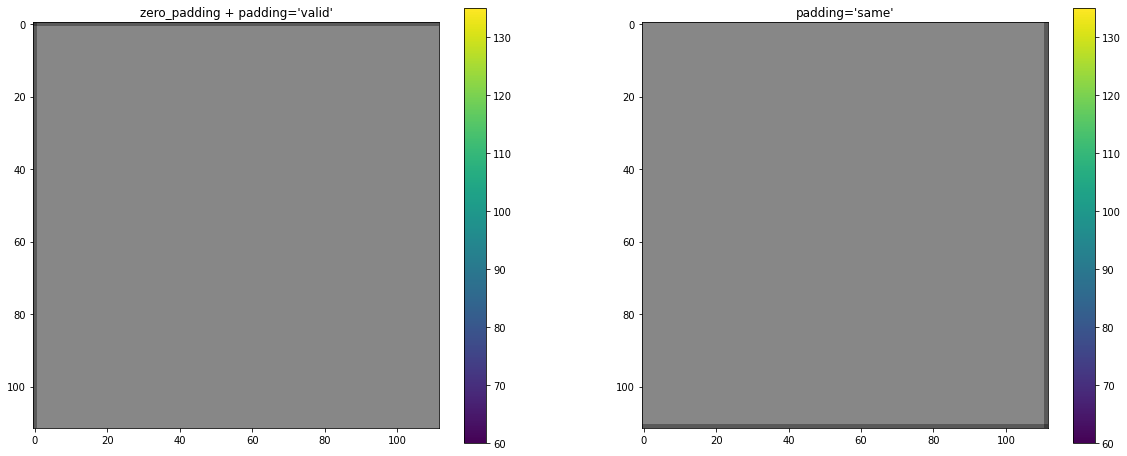

In [37]:
plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
plt.imshow(tf.cast(x_1[0], dtype=tf.int32))
plt.title("zero_padding + padding='valid'")
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(tf.cast(x_3[0], dtype=tf.int32))
plt.title("padding='same'")
plt.colorbar()

plt.show()

> **note**:
> - `input_shape`이 `(224, 224, 3)`일 경우에는 위와 같이 약간의 차이가 발생한다.(**zero_padding + padding='valid'**의 경우 좌상단 부분에 패딩으로 인한 값 차이가 나타나고, **padding='same'**의 경우 우하단 부분에 값 차이가 나타난다.
> - 이는 `Conv2D` 레이어의 `padding` 파라미터 차이 때문이 아닌가 싶은데, `ZeroPadding2D`는 예상하는 것과 같이 맨 처음에 좌우상하 모든 부분에 `0`을 1칸씩 채워서 이미지 크기를 `(226, 226)`으로 키운다.
> - 그리고 차이가 나타나는 `padding` 파라미터에서 `'valid'`의 경우, `kernel_size=(3, 3) & strides=(2, 2)`이면 `(226, 226)` 사이즈에서 제일 우측, 그리고 제일 밑 부분의 1칸씩은 행렬곱에서 제외되어버린다.
> - 그러나 ZeroPadding2D를 거치지 않고 `padding='same'`을 지정하게 되면 맨 왼쪽과 오른쪽은 일단 패딩하지 않은 상태인 `(224, 224)`로 쭉 행렬곱 하다가 마지막 제일 왼쪽 끝과 밑쪽에서 1칸씩 남게 되고, `'same'`지정으로 인해 그 부분에서 `0`이 다시 오르쪽 혹은 밑쪽으로 1칸씩 붙어서 행렬곱을 한 번 더 하게끔 해준다.(이로서 `(112, 112)` 사이즈의 output이 나오게끔)
> - 이러다 보니 위의 조건이면 `(224, 224)` 같이 짝수인 `input_shape`일 경우 어느 부분에서 padding의 값 차이가 나는지 달라지게 되는데, 예상하기로는 `(225, 225)` 같이 홀수가 될 경우 이미지 양 옆에 똑같이 패딩이 이루어지게 될 것 같다.
> - 한 번 확인해보자.

In [38]:
# 실험
# 베이스 텐서 생성
initializer = tf.keras.initializers.constant(value=5) # kernel weight을 고정시키기
t_input_shape = (1, 225, 225, 3) # input shape 홀수로 변경
t = tf.ones(t_input_shape)
print(f'original shape : {t.shape}')

# zero_padding + padding='valid'
x = tf.keras.layers.ZeroPadding2D(padding=((1, 1), (1, 1)))(t)
x_1 = tf.keras.layers.Conv2D(3, (3, 3), padding='valid', strides=(2, 2), kernel_initializer=initializer)(x)
print(f"zero_padding + padding='valid' shape : {x_1.shape}")

# padding='valid'
x_2 = tf.keras.layers.Conv2D(3, (3, 3), padding='valid', strides=(2, 2), kernel_initializer=initializer)(t)
print(f"padding='valid' shape : {x_2.shape}")

# padding='same'
x_3 = tf.keras.layers.Conv2D(3, (3, 3), padding='same', strides=(2, 2), kernel_initializer=initializer)(t)
print(f"padding='same' shape : {x_3.shape}")

original shape : (1, 225, 225, 3)
zero_padding + padding='valid' shape : (1, 113, 113, 3)
padding='valid' shape : (1, 112, 112, 3)
padding='same' shape : (1, 113, 113, 3)


In [39]:
print(f"x_1 min : {tf.reduce_min(x_1)}, max : {tf.reduce_max(x_1)}")
print(f"x_3 min : {tf.reduce_min(x_3)}, max : {tf.reduce_max(x_3)}")

x_1 min : 60.0, max : 135.0
x_3 min : 60.0, max : 135.0


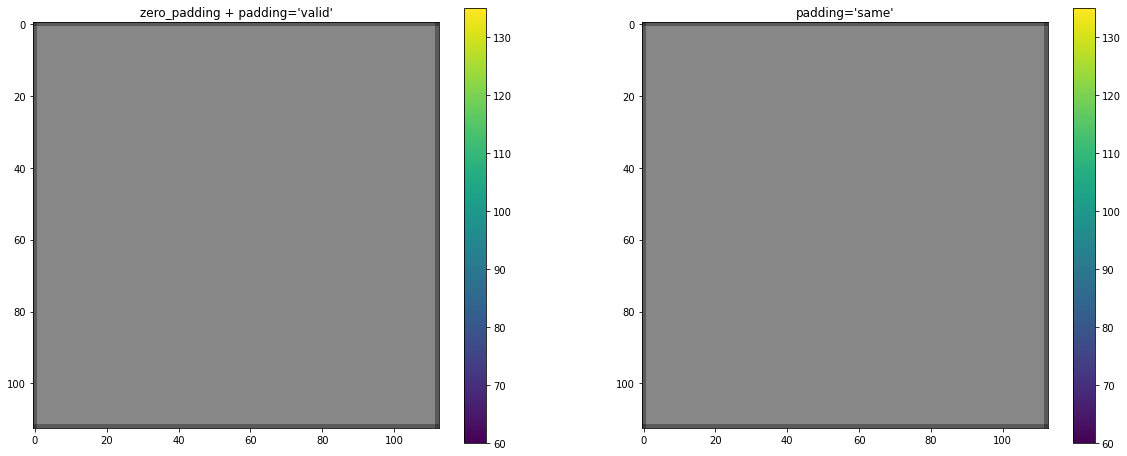

In [40]:
plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
plt.imshow(tf.cast(x_1[0], dtype=tf.int32))
plt.title("zero_padding + padding='valid'")
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(tf.cast(x_3[0], dtype=tf.int32))
plt.title("padding='same'")
plt.colorbar()

plt.show()

In [41]:
# 값이 정확히 일치하는지도 확인
(x_1 == x_3).numpy().all()

True

> **note**:
> - 예상한 것과 같이 양 이미지 좌우상하 모든 측면에 padding이 필요하게 되는 이미지 사이즈의 경우 `ZeroPadding2D + Conv2D(padding='valid'`과 `Conv2D(padding='same')`이 같은 로직으로 구현되는 것을 확인했다.

#### Depthwise Conv Block
- 원래 논문에서 쓰인 SSD 모델에는 Depthwise Convolution은 사용되지 않는 것 같다.
- 위의 일반적인 conv_block과 다른 점은 Depthwise Convolution + BN + ReLU 후 일반 Convolution + BN + ReLU를 겪게 한다는 점이다.

In [42]:
def _depthwise_conv_block(inputs, filters, strides=(1, 1)):
    block_id = tf.keras.backend.get_uid()
    if strides == (1, 1):
        x = inputs
    else:
        x = tf.keras.layers.ZeroPadding2D(((1, 1), (1, 1)), name='conv_pad_%d' % block_id)(inputs)
    x = tf.keras.layers.DepthwiseConv2D((3, 3),
                                        padding='same' if strides == (1, 1) else 'valid',
                                        strides=strides,
                                        use_bias=False,
                                        name='conv_dw_%d' % block_id)(x)
    x = tf.keras.layers.BatchNormalization(name='conv_dw_%d_bn' % block_id)(x)
    x = tf.keras.layers.ReLU(name='conv_dw_%d_relu' % block_id)(x)
    x = tf.keras.layers.Conv2D(filters, (1, 1),
                               padding='same',
                               use_bias=False,
                               strides=(1, 1),
                               name='conv_pw_%d' % block_id)(x)
    x = tf.keras.layers.BatchNormalization(name='conv_pw_%d_bn' % block_id)(x)
    return tf.keras.layers.ReLU(name='conv_pw_%d_relu' % block_id)(x)

#### 중간에 feature map을 뽑아주는 블록 함수(?)

In [43]:
def _branch_block(inputs, filters):
    x = tf.keras.layers.Conv2D(filters, kernel_size=(3, 3), padding='same')(inputs)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Conv2D(filters, kernel_size=(3, 3), padding='same')(x)
    x1 = tf.keras.layers.Conv2D(filters * 2, kernel_size=(3, 3), padding='same')(inputs)
    x = tf.keras.layers.Concatenate(axis=-1)([x, x1])
    return tf.keras.layers.ReLU()(x)

#### Head 부분 생성 함수

In [44]:
def _create_head_block(inputs, filters):
    x = tf.keras.layers.Conv2D(filters, kernel_size=(3, 3), strides=(1, 1), padding='same')(inputs)
    return x

In [45]:
def _compute_heads(inputs, num_class, num_cell):
    conf = _create_head_block(inputs, num_cell * num_class)
    conf = tf.keras.layers.Reshape((-1, num_class))(conf)
    loc = _create_head_block(inputs, num_cell * 4)
    loc = tf.keras.layers.Reshape((-1, 4))(loc)
    return conf, loc

#### 모델 빌드 함수

In [46]:
def SsdModel():
    base_channel = 16
    num_cells = [3, 2, 2, 3]
    num_class = len(IMAGE_LABELS)  # IMAGE_LABELS = ['background', 'face']
    
    x = inputs = tf.keras.layers.Input(shape=[IMAGE_HEIGHT, IMAGE_WIDTH, 3], name='input_image')

    x = _conv_block(x, base_channel, strides=(2, 2))
    x = _conv_block(x, base_channel * 2, strides=(1, 1))
    x = _conv_block(x, base_channel * 2, strides=(2, 2))
    x = _conv_block(x, base_channel * 2, strides=(1, 1))
    x = _conv_block(x, base_channel * 4, strides=(2, 2))
    x = _conv_block(x, base_channel * 4, strides=(1, 1))
    x = _conv_block(x, base_channel * 4, strides=(1, 1))
    x = _conv_block(x, base_channel * 4, strides=(1, 1))
    x1 = _branch_block(x, base_channel)

    x = _conv_block(x, base_channel * 8, strides=(2, 2))
    x = _conv_block(x, base_channel * 8, strides=(1, 1))
    x = _conv_block(x, base_channel * 8, strides=(1, 1))
    x2 = _branch_block(x, base_channel)

    x = _depthwise_conv_block(x, base_channel * 16, strides=(2, 2))
    x = _depthwise_conv_block(x, base_channel * 16, strides=(1, 1))
    x3 = _branch_block(x, base_channel)

    x = _depthwise_conv_block(x, base_channel * 16, strides=(2, 2))
    x4 = _branch_block(x, base_channel)

    extra_layers = [x1, x2, x3, x4]

    confs = []
    locs = []

    for layer, num_cell in zip(extra_layers, num_cells):
        conf, loc = _compute_heads(layer, num_class, num_cell)
        confs.append(conf)
        locs.append(loc)

    confs = tf.keras.layers.Concatenate(axis=1, name="face_classes")(confs)
    locs = tf.keras.layers.Concatenate(axis=1, name="face_boxes")(locs)

    predictions = tf.keras.layers.Concatenate(axis=2, name='predictions')([locs, confs])

    model = tf.keras.Model(inputs=inputs, outputs=predictions, name='ssd_model')
    return model

In [47]:
# 모델 생성
model = SsdModel()
print("the number of model layers: ", len(model.layers))
model.summary()

the number of model layers:  101
Model: "ssd_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_image (InputLayer)       [(None, 256, 320, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv_pad_1 (ZeroPadding2D)     (None, 258, 322, 3)  0           ['input_image[0][0]']            
                                                                                                  
 conv_1 (Conv2D)                (None, 128, 160, 16  432         ['conv_pad_1[0][0]']             
                                )                                                                 
                                                         

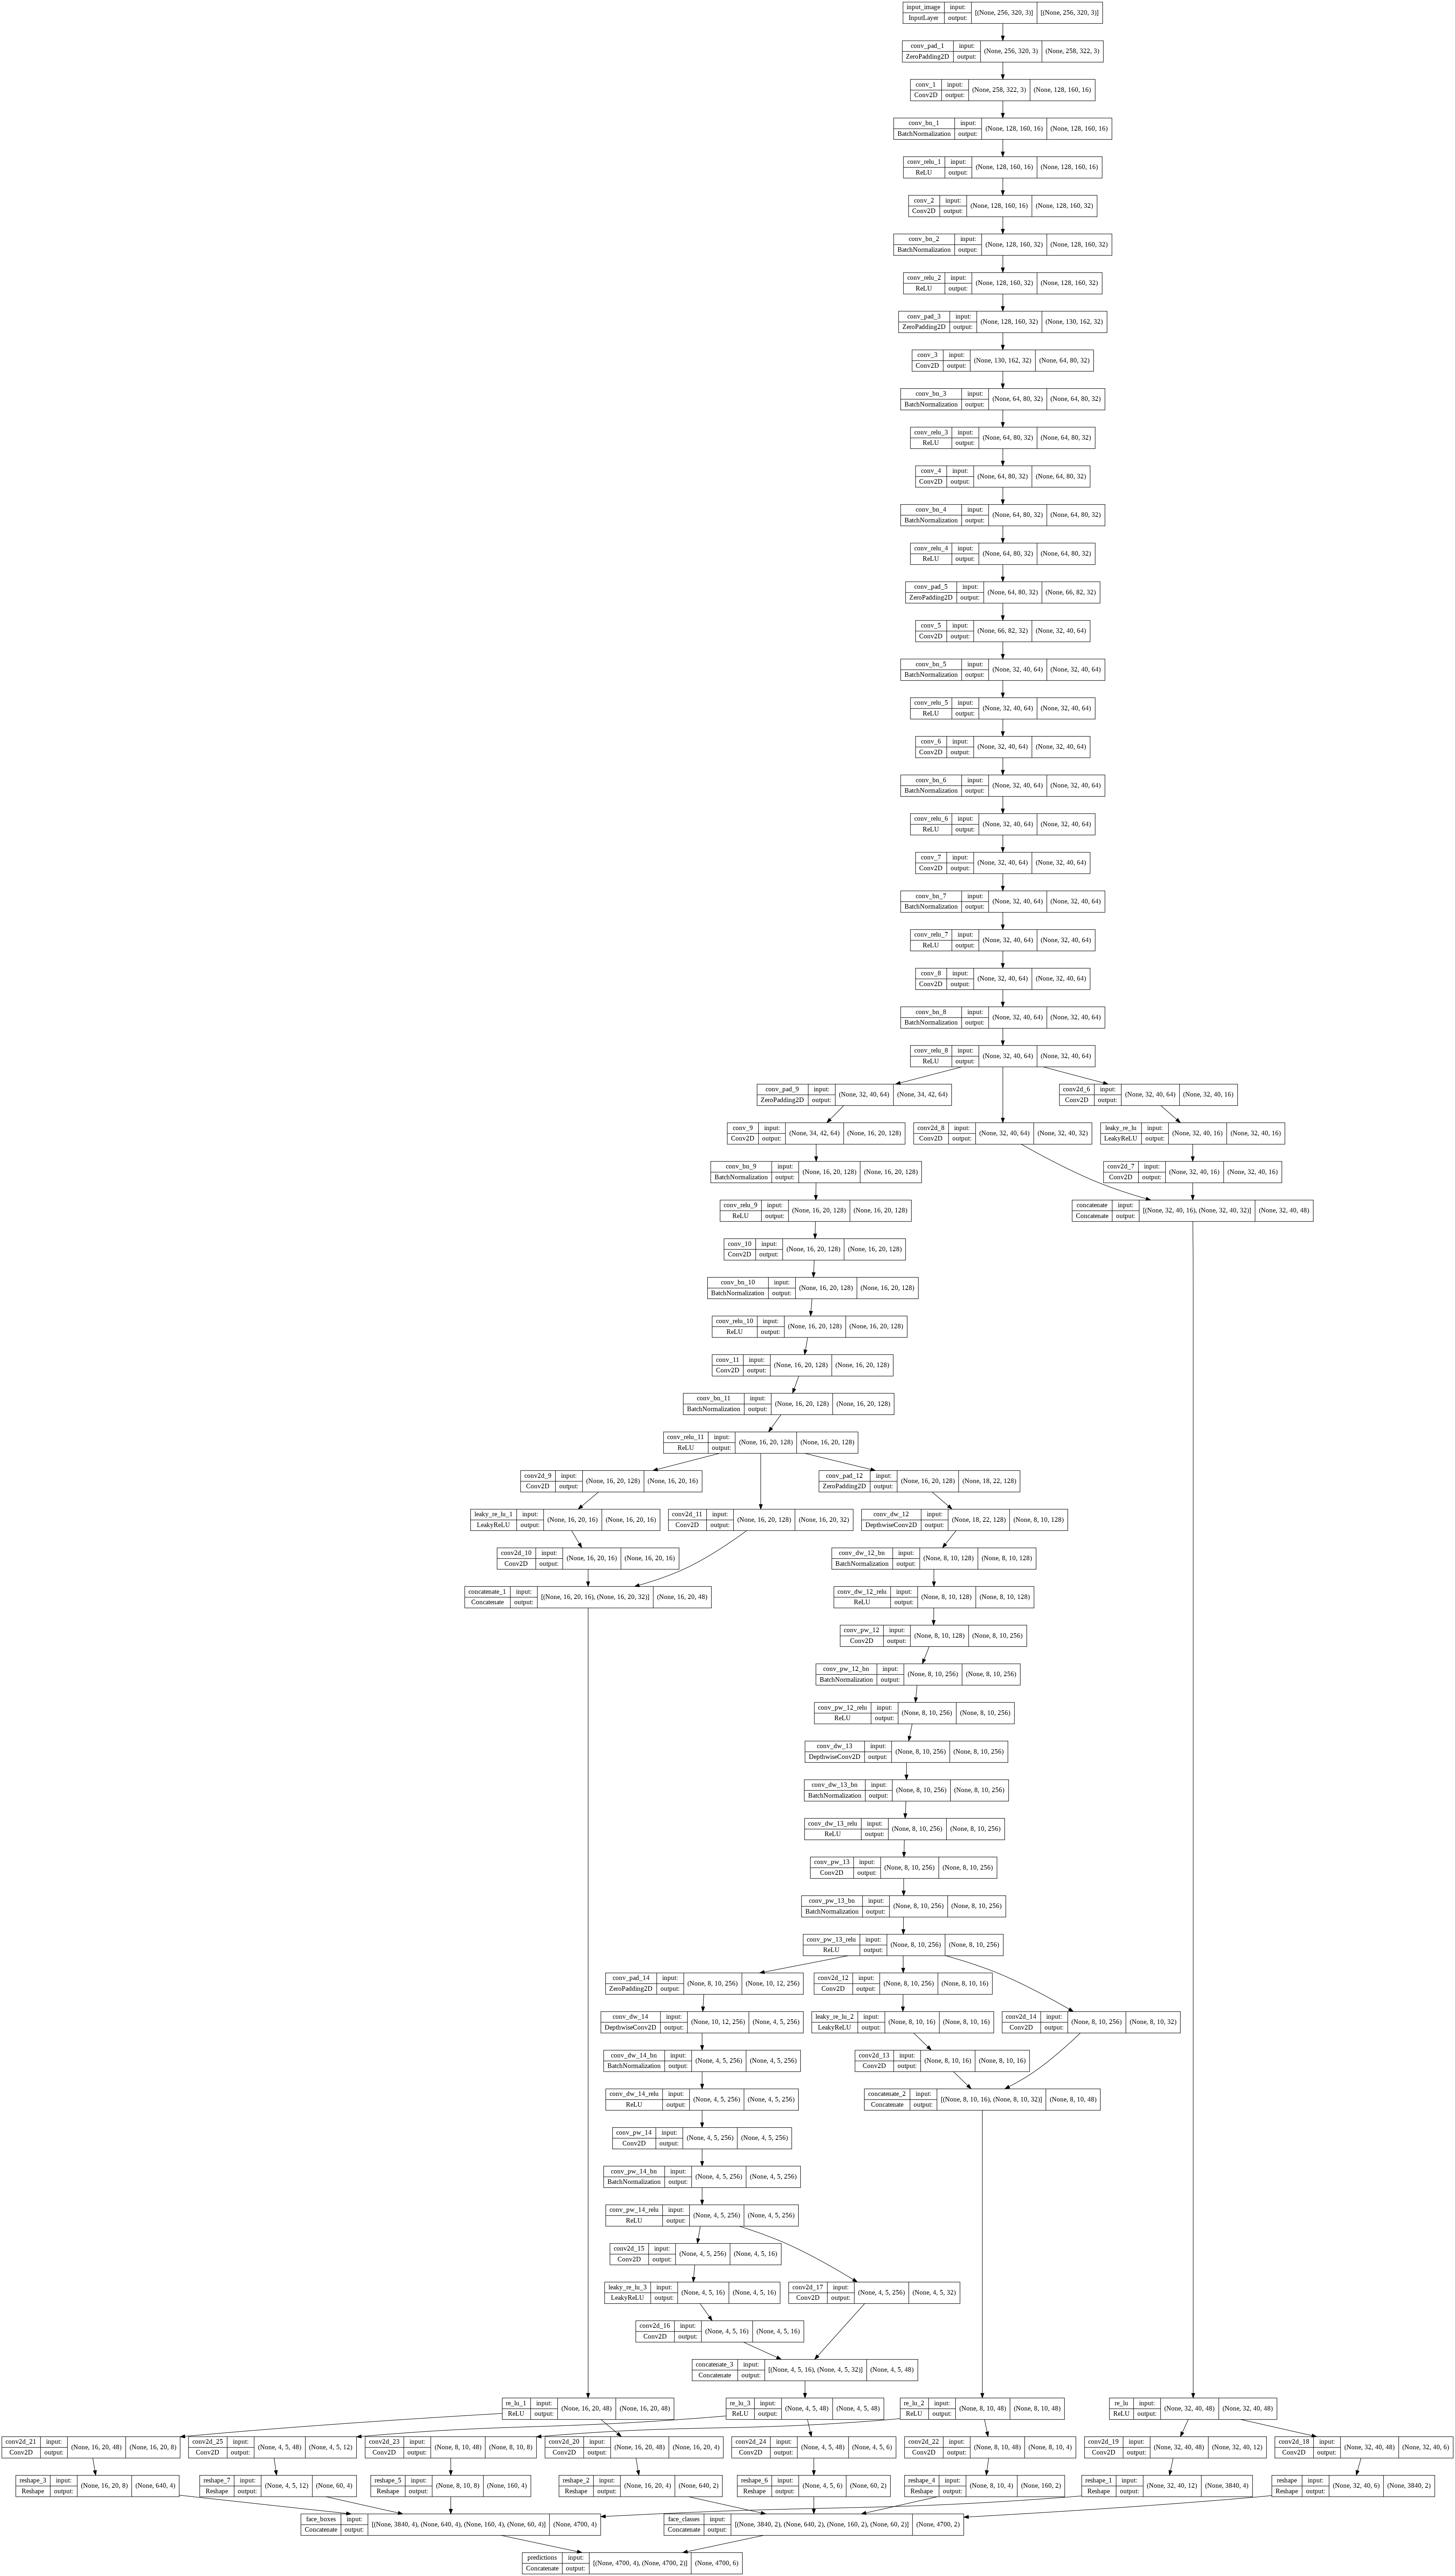

In [48]:
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True)

### 7) 모델 컴파일 및 훈련
---


In [49]:
class PiecewiseConstantWarmUpDecay(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, boundaries, values, warmup_steps, min_lr, name=None):
        super(PiecewiseConstantWarmUpDecay, self).__init__()

        if len(boundaries) != len(values) - 1:
            raise ValueError(
                    "The length of boundaries should be 1 less than the"
                    "length of values")

        self.boundaries = boundaries
        self.values = values
        self.name = name
        self.warmup_steps = warmup_steps
        self.min_lr = min_lr

    def __call__(self, step):
        with tf.name_scope(self.name or "PiecewiseConstantWarmUp"):
            step = tf.cast(tf.convert_to_tensor(step), tf.float32)
            pred_fn_pairs = []
            warmup_steps = self.warmup_steps
            boundaries = self.boundaries
            values = self.values
            min_lr = self.min_lr

            pred_fn_pairs.append(
                (step <= warmup_steps,
                 lambda: min_lr + step * (values[0] - min_lr) / warmup_steps))
            pred_fn_pairs.append(
                (tf.logical_and(step <= boundaries[0],
                                step > warmup_steps),
                 lambda: tf.constant(values[0])))
            pred_fn_pairs.append(
                (step > boundaries[-1], lambda: tf.constant(values[-1])))

            for low, high, v in zip(boundaries[:-1], boundaries[1:],
                                    values[1:-1]):
                pred = (step > low) & (step <= high)
                pred_fn_pairs.append((pred, lambda: tf.constant(v)))

            return tf.case(pred_fn_pairs, lambda: tf.constant(values[0]),
                           exclusive=True)

In [50]:
def MultiStepWarmUpLR(initial_learning_rate, lr_steps, lr_rate,
                      warmup_steps=0., min_lr=0.,
                      name='MultiStepWarmUpLR'):
    assert warmup_steps <= lr_steps[0]
    assert min_lr <= initial_learning_rate
    lr_steps_value = [initial_learning_rate]
    for _ in range(len(lr_steps)):
        lr_steps_value.append(lr_steps_value[-1] * lr_rate)
    return PiecewiseConstantWarmUpDecay(
        boundaries=lr_steps, values=lr_steps_value, warmup_steps=warmup_steps,
        min_lr=min_lr)

In [51]:
def hard_negative_mining(loss, class_truth, neg_ratio):
    pos_idx = class_truth > 0
    num_pos = tf.math.reduce_sum(tf.cast(pos_idx, tf.int32), axis=1)
    num_neg = num_pos * neg_ratio

    rank = tf.argsort(loss, axis=1, direction='DESCENDING')
    rank = tf.argsort(rank, axis=1)
    neg_idx = rank < tf.expand_dims(num_neg, 1)

    return pos_idx, neg_idx

In [52]:
def MultiBoxLoss(num_class, neg_pos_ratio=3.0):
    def multi_loss(y_true, y_pred):
        num_batch = tf.shape(y_true)[0]
        loc_pred, class_pred = y_pred[..., :4], y_pred[..., 4:]
        loc_truth, class_truth = y_true[..., :4], tf.squeeze(y_true[..., 4:])

        cross_entropy = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
        temp_loss = cross_entropy(class_truth, class_pred)
        pos_idx, neg_idx = hard_negative_mining(temp_loss, class_truth, neg_pos_ratio)

        cross_entropy = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='sum')
        loss_class = cross_entropy(
            class_truth[tf.math.logical_or(pos_idx, neg_idx)],
            class_pred[tf.math.logical_or(pos_idx, neg_idx)])
        
        smooth_l1_loss = tf.keras.losses.Huber(reduction='sum')
        loss_loc = smooth_l1_loss(loc_truth[pos_idx],loc_pred[pos_idx])

        num_pos = tf.math.reduce_sum(tf.cast(pos_idx, tf.float32))

        loss_class = loss_class / num_pos
        loss_loc = loss_loc / num_pos
        return loss_loc, loss_class

    return multi_loss

In [53]:
steps_per_epoch = DATASET_LEN // BATCH_SIZE
learning_rate = MultiStepWarmUpLR(
    initial_learning_rate=1e-2,
    lr_steps=[e*steps_per_epoch for e in [50, 70]],
    lr_rate=0.1,
    warmup_steps=5*steps_per_epoch,
    min_lr=1e-4
)
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9, nesterov=True)

multi_loss = MultiBoxLoss(len(IMAGE_LABELS), neg_pos_ratio=3)

In [54]:
@tf.function
def train_step(inputs, labels):
    with tf.GradientTape() as tape:
        predictions = model(inputs, training=True)
        losses = {}
        losses['reg'] = tf.reduce_sum(model.losses)  #unused. Init for redefine network
        losses['loc'], losses['class'] = multi_loss(labels, predictions)
        total_loss = tf.add_n([l for l in losses.values()])

    grads = tape.gradient(total_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    return total_loss, losses

In [55]:
# EPOCHS = 50

# for epoch in range(0, EPOCHS):
#     for step, (inputs, labels) in enumerate(train_dataset.take(steps_per_epoch)):
#         load_t0 = time.time()
#         total_loss, losses = train_step(inputs, labels)
#         load_t1 = time.time()
#         batch_time = load_t1 - load_t0
#         print(f"\rEpoch: {epoch + 1}/{EPOCHS} | Batch {step + 1}/{steps_per_epoch} \
#         | Batch time {batch_time:.3f} || Loss: {total_loss:.6f} | loc loss:{losses['loc']:.6f} \
#         | class loss:{losses['class']:.6f} ",end = '',flush=True)

#     filepath = os.path.join(CHECKPOINT_PATH, f'weights_epoch_{(epoch + 1):03d}.h5')
#     model.save_weights(filepath)

In [56]:
weights_path = '/content/drive/My Drive/Aiffel/GD_14/raw_checkpoints/weights_epoch_050.h5'
model.load_weights(weights_path)

### 8) Inference
---
- 사진 내 얼굴을 예측하고, bbox를 통해 예측 결과를 시각화한다.

#### 유틸리티 함수들

In [57]:
def compute_nms(boxes, scores, nms_threshold=0.4, limit=200):
    if boxes.shape[0] == 0:
        return tf.constant([], dtype=tf.int32)
    selected = [0]
    idx = tf.argsort(scores, direction='DESCENDING')
    idx = idx[:limit]
    boxes = tf.gather(boxes, idx)

    iou = _jaccard(boxes, boxes)

    while True:
        row = iou[selected[-1]]
        next_indices = row <= nms_threshold

        iou = tf.where(
            tf.expand_dims(tf.math.logical_not(next_indices), 0),
            tf.ones_like(iou, dtype=tf.float32),
            iou
        )

        if not tf.math.reduce_any(next_indices):
            break

        selected.append(tf.argsort(
            tf.dtypes.cast(next_indices, tf.int32), direction='DESCENDING')[0].numpy())

    return tf.gather(idx, selected)

In [58]:
def decode_bbox_tf(predicts, boxes, variances=[0.1, 0.2]):
    centers = boxes[:, :2] + predicts[:, :2] * variances[0] * boxes[:, 2:]
    sides = boxes[:, 2:] * tf.math.exp(predicts[:, 2:] * variances[1])
    return tf.concat([centers - sides / 2, centers + sides / 2], axis=1)

In [59]:
def parse_predict(predictions, boxes):
    label_classes = IMAGE_LABELS

    bbox_predictions, confidences = tf.split(predictions[0], [4, -1], axis=-1)
    boxes = decode_bbox_tf(bbox_predictions, boxes)

    scores = tf.math.softmax(confidences, axis=-1)

    out_boxes = []
    out_labels = []
    out_scores = []

    for c in range(1, len(label_classes)):
        cls_scores = scores[:, c]

        score_idx = cls_scores > 0.5

        cls_boxes = boxes[score_idx]
        cls_scores = cls_scores[score_idx]

        nms_idx = compute_nms(cls_boxes, cls_scores)

        cls_boxes = tf.gather(cls_boxes, nms_idx)
        cls_scores = tf.gather(cls_scores, nms_idx)

        cls_labels = [c] * cls_boxes.shape[0]

        out_boxes.append(cls_boxes)
        out_labels.extend(cls_labels)
        out_scores.append(cls_scores)

    out_boxes = tf.concat(out_boxes, axis=0)
    out_scores = tf.concat(out_scores, axis=0)

    boxes = tf.clip_by_value(out_boxes, 0.0, 1.0).numpy()
    classes = np.array(out_labels)
    scores = out_scores.numpy()

    return boxes, classes, scores

In [60]:
def pad_input_image(img, max_steps):
    img_h, img_w, _ = img.shape

    img_pad_h = 0
    if img_h % max_steps > 0:
        img_pad_h = max_steps - img_h % max_steps

    img_pad_w = 0
    if img_w % max_steps > 0:
        img_pad_w = max_steps - img_w % max_steps

    padd_val = np.mean(img, axis=(0, 1)).astype(np.uint8)
    img = cv2.copyMakeBorder(img, 0, img_pad_h, 0, img_pad_w,
                             cv2.BORDER_CONSTANT, value=padd_val.tolist())
    pad_params = (img_h, img_w, img_pad_h, img_pad_w)

    return img, pad_params

In [61]:
def recover_pad(boxes, pad_params):
    img_h, img_w, img_pad_h, img_pad_w = pad_params
    box = np.reshape(boxes[0], [-1, 2, 2]) * [(img_pad_w + img_w) / img_w, (img_pad_h + img_h) / img_h]
    boxes[0] = np.reshape(box, [-1, 4])
    return boxes

In [62]:
def draw_box_on_face(img, boxes, classes, scores, box_index, class_list):
    img_height = img.shape[0]
    img_width = img.shape[1]

    x_min = int(boxes[box_index][0] * img_width)
    y_min = int(boxes[box_index][1] * img_height)
    x_max = int(boxes[box_index][2] * img_width)
    y_max = int(boxes[box_index][3] * img_height)

    if classes[box_index] == 1:
        color = (0, 255, 0)
    else:
        color = (0, 0, 255)
    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color, 2)
    
    if len(scores) > box_index :
        score = "{:.4f}".format(scores[box_index])
        class_name = class_list[classes[box_index]]
        label = '{} {}'.format(class_name, score)
        position = (x_min, y_min - 4) 
        cv2.putText(img, label, position, cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255))

#### 결과 시각화

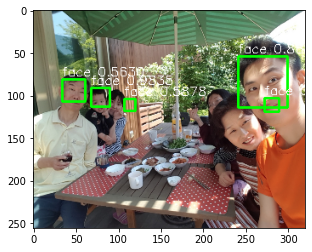

In [63]:
# filepath = os.path.join(PROJECT_PATH, 'checkpoints', 'weights_epoch_010.h5')
# model.save_weights(filepath)

TEST_IMAGE_PATH = os.path.join(ROOT_PATH, 'image.png')

img_raw = cv2.imread(TEST_IMAGE_PATH)
img_raw = cv2.resize(img_raw, (IMAGE_WIDTH, IMAGE_HEIGHT))
img = np.float32(img_raw.copy())

img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img, pad_params = pad_input_image(img, max_steps=max(BOX_STEPS))
img = img / 255.0

boxes = default_box()
boxes = tf.cast(boxes, tf.float32)

predictions = model.predict(img[np.newaxis, ...])

pred_boxes, labels, scores = parse_predict(predictions, boxes)
pred_boxes = recover_pad(pred_boxes, pad_params)

for box_index in range(len(pred_boxes)):
    draw_box_on_face(img_raw, pred_boxes, labels, scores, box_index, IMAGE_LABELS)

img_raw = cv2.cvtColor(img_raw, cv2.COLOR_BGR2RGB)
plt.imshow(img_raw)
plt.show()

In [64]:
print(f"predictions shape : {predictions.shape}")
print(f"pred_boxes shape : {pred_boxes.shape}")
print(f"labels : {labels}")
print(f"scores : {scores}")

predictions shape : (1, 4700, 6)
pred_boxes shape : (5, 4)
labels : [1 1 1 1 1]
scores : [0.9834975  0.8684039  0.6628813  0.5878214  0.56298625]


> **note**:
> - 이제 해당 구조를 통해 예측된 결과에 스티커를 붙여볼 예정이다. 현재 구현된 것들 중 스티커 붙이기에 이용될 것들을 파헤쳐보면,
> - bbox 좌표는 `pred_boxes`라는 변수에 `(bbox 개수, 4)` shape으로 저장되어 있다. 이는 추후 `draw_box_on_face` 함수에서 `(x_min, y_min, x_max, y_max)`로 쓰여서 bbox 그릴 때 쓰이고 있다.
> - 여기서 스티커를 붙이려면 새로 만들 `attach_sticker()` 함수를 이용해 bbox 내 적절한 위치에 맞춰 스티커가 붙게끔 해주면 될 듯하다.(이를 위해선 스티커의 크기 resize가 먼저 진행되어야 할 것 같다.)

#### 스티커 불러오기

In [65]:
print(STICKER_PATH)
sticker_img = cv2.imread(STICKER_PATH, cv2.IMREAD_UNCHANGED)
sticker_img = cv2.cvtColor(sticker_img, cv2.COLOR_BGRA2RGBA)
print(sticker_img.shape)
sticker_resized = sticker_img[140:380, 70:320, :] # 원활하게 붙일 수 있게 그 영역만 따로 떼어내기
print(sticker_resized.shape)

/content/drive/My Drive/Aiffel/GD_14/sticker.png
(366, 388, 4)
(226, 250, 4)


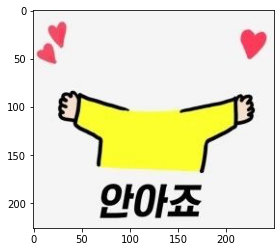

In [66]:
# 사용할 이미지 확인
plt.imshow(sticker_resized)

In [67]:
# 복사본 만들어서 사용
import copy
sticker_resized_copy = copy.deepcopy(sticker_resized)

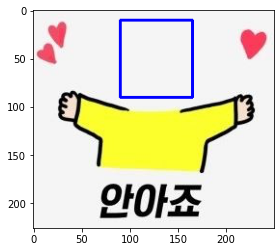

In [68]:
# 예상 face bbox 위치
plt.imshow(cv2.rectangle(sticker_resized_copy, (90, 10), (165, 90), (0, 0, 255, 255), 2))

In [69]:
# 복사본 다시 만들기
sticker_resized_copy = copy.deepcopy(sticker_resized)

> **note**:
> - 위의 `cv2.rectangle()`에서 인풋이 4채널이어서 `color=(R, G, B, A)`순으로 되고, A는 0이면 투명해지고 255로 갈수록 불투명해진다.
> - 얼굴 검출 영역에 스티커를 붙이는 것에 대해서는 저 정도 위치에 얼굴이 들어오게 하면 되지 않을까 싶다.
> - 저 부분에 bbox가 대략 들어오게끔 하는 것이 목표인데, 그러려면 전체 이미지에서 저 부분이 해당하는 비율과 나머지 부분(좌우상하)이 해당하는 비율을 구해서 bbox 좌표를 실제 이미지 크기로 키울 때 맞춰서 키워보면 될 듯하다.
>   - 좀 더 부연 설명하자면, 현재 bbox를 그리는 구조는 0 ~ 1 사이의 값으로 normalise된 값을 이미지 크기를 곱함으로서 실제 이미지에 해당하는 좌표값을 얻는 것인데,
>   - 스티커의 좌표도 bbox와 마찬가지로 상대적인(0 ~ 1 사이의) 좌표 값으로 잡아놓고, 이미지 크기와 곱함으로서 실제 이미지에 해당하는 좌표 값을 얻어볼 것이다.
>   - 그런데 스티커의 좌표를 구하려면 bbox와 스티커 간의 고정된 비율을 잡는 것이 중요한데, 해당 방법은 아래의 사진을 보면 이해할 수 있다.
>   - 요약하면, bbox 값을 통해 0 ~ 1 사이의 width, height 값을 구하고, 스티커 이미지 내 해당 거리와 모서리에 대한 비율을 구해서 동일한 scale로 맞추고, bbox LT, BR에서 해당 거리 만큼을 빼고 더해서 스티커 이미지의 LT, BR 좌표를 구해놓는 것이다.

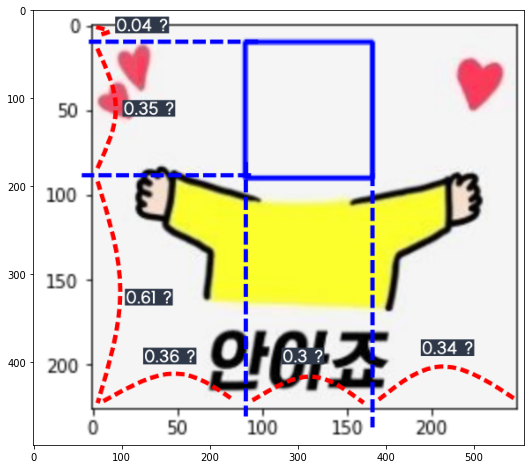

In [70]:
# 아이디어 요약된 그림 가져오기
proto_img = cv2.imread(ROOT_PATH + '/proto.png')
proto_img = cv2.cvtColor(proto_img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10,8))
plt.imshow(proto_img)
plt.show()

#### 스티커의 상대적 위치 값들 구하기

In [71]:
h = sticker_resized.shape[0] # 실제 스티커 이미지 height
w = sticker_resized.shape[1] # 실제 스티커 이미지 width

In [72]:
h_offset_up = round(10/h, 2) # 스티커 내 맨 위쪽에서 bbox까지의 거리 비율
h_bbox = round(80/h, 2) # 스티커 내 bbox 부분 비율
h_offset_down = 1 - h_offset_up - h_bbox # 위의 두 부분 제외한 부분의 비율(높이)

print(h_offset_up, h_bbox, h_offset_down)

0.04 0.35 0.61


In [73]:
w_offset_left = round(90/w, 2) # 스티커 내 맨 위쪽에서 bbox까지의 거리 비율
w_bbox = round(75/w, 2) # 스티커 내 bbox 부분 비율
w_offset_right = 1 - w_offset_left - w_bbox # 위의 두 부분 제외한 부분의 비율(넓이)

print(w_offset_left, w_bbox, w_offset_right)

0.36 0.3 0.34


#### `attach_sticker()` 함수 생성

In [74]:
def attach_sticker(img, sticker_img, boxes, box_index, h_offset_up, h_bbox, h_offset_down, w_offset_left, w_bbox, w_offset_right):
    
    if img.max() <= 1:
        img = (img * 255).astype(np.uint8) # -------------------> denormalise(스티커와의 scale을 맞춰주기 위해)

    img_height = img.shape[0]              # -------------------> img 사이즈 저장 
    img_width = img.shape[1]
    
    normalised_x_min = boxes[box_index][0] # -------------------> 현재 박스들의 normalise된 x_min, y_min, x_max, y_max 저장
    normalised_y_min = boxes[box_index][1]
    normalised_x_max = boxes[box_index][2]
    normalised_y_max = boxes[box_index][3]
    # print(f"n_xmin : {normalised_x_min}")
    # print(f"n_ymin : {normalised_y_min}")
    # print(f"n_xmax : {normalised_x_max}")
    # print(f"n_ymax : {normalised_y_max}")

    normalised_width = normalised_x_max - normalised_x_min # ----------> 현재 박스들의 normalise된 width, height 저장
    normalised_height = normalised_y_max - normalised_y_min
    # print(f"n_width : {normalised_width}")
    # print(f"n_height : {normalised_height}")
    
    n_sticker_x_min = tf.math.maximum(normalised_x_min - (normalised_width * w_offset_left / w_bbox), 0) # ---------> 인자로 받는 스티커 내 파티션 비율과
    n_sticker_y_min = tf.math.maximum(normalised_y_min - (normalised_height * h_offset_up / h_bbox), 0)  # ---------> normalise된 bbox 넓이, 크기를 통해 
    n_sticker_x_max = tf.math.minimum(normalised_x_max + (normalised_width * w_offset_right / w_bbox), 1) # --------> normalise된 스티커의 좌표 값 찾기
    n_sticker_y_max = tf.math.minimum(normalised_y_max + (normalised_height * h_offset_down / h_bbox), 1)
    # print(f"n_sticker_x_min : {n_sticker_x_min}")
    # print(f"n_sticker_y_min : {n_sticker_y_min}")
    # print(f"n_sticker_x_max : {n_sticker_x_max}")
    # print(f"n_sticker_y_max : {n_sticker_y_max}")    

    x_min = int(boxes[box_index][0] * img_width) # --------------> 실제 이미지 크기에 맞는 bbox 좌표 값
    y_min = int(boxes[box_index][1] * img_height)
    x_max = int(boxes[box_index][2] * img_width)
    y_max = int(boxes[box_index][3] * img_height)

    sticker_x_min = int(n_sticker_x_min * img_width) # ----------> 실제 이미지 크기에 맞는 스티커 좌표 값
    sticker_y_min = int(n_sticker_y_min * img_height)
    sticker_x_max = int(n_sticker_x_max * img_width)
    sticker_y_max = int(n_sticker_y_max * img_height)
    # print(f"xmin : {sticker_x_min}")
    # print(f"ymin : {sticker_y_min}")
    # print(f"xmax : {sticker_x_max}")
    # print(f"ymax : {sticker_y_max}")

    sticker_width = sticker_x_max - sticker_x_min # -------------> 실제 이미지 크기에 맞는 스티커 넓이, 높이
    sticker_height = sticker_y_max - sticker_y_min
    # print("sticker_width", sticker_width)
    # print("sticker_height", sticker_height)
    # print(sticker_img.shape, "<=== 3")
    sticker_img = cv2.resize(sticker_img, (sticker_width, sticker_height)) # -------> 필요한 크기만큼 스티커 리사이즈
    # print("sticker_img.shape :", sticker_img.shape)
    # print("sticker_min :", sticker_img.min())
    # print("sticker_max :", sticker_img.max())

    img_copy = copy.deepcopy(img)
    # img_copy = cv2.cvtColor(img_copy, cv2.COLOR_RGB2RGBA)
    sticker_img = cv2.cvtColor(sticker_img, cv2.COLOR_RGBA2RGB)
    # condition = sticker_img[:, :, 3] == 255
    # condition = np.stack([condition, condition, condition], axis=-1)
    
    condition = sticker_img >= 245        # ----------------------------------------> 스티커 이미지 영역에서 masking할 조건

    img_copy[sticker_y_min:sticker_y_max, sticker_x_min:sticker_x_max, :] = \
    np.where(condition, img_copy[sticker_y_min:sticker_y_max, sticker_x_min:sticker_x_max, :], sticker_img[:, :, :]).astype(np.uint8)
    # print("sticker_added.max :", sticker_added.max())
    # img_copy_area = sticker_added
    # print("img_copy_area.shape :", img_copy_area.shape)
 
    return img_copy

> **note**:
> - 여기서 최종 목표는 이미지에서 스티커를 갖다 붙일 `(x_min, y_min)`과 `(x_max, y_max)` 좌표 두 개를 찾는 것이다.
> - 즉, 얼굴의 bbox 좌표를 통해서 이미지상에서의 스티커 좌상단 좌표와 우하단 좌표를 찾아내고, 그 좌표 내의 image를 서로 blending하는 것이 목표이다.

In [75]:
# 위의 함수를 통해 여러 개 object에 스티커를 붙일 경우 어떻게 되는지 확인
img_list = []
for index in range(len(pred_boxes)):
    img_list.append(attach_sticker(img, sticker_resized_copy, pred_boxes, index, h_offset_up, h_bbox, h_offset_down, w_offset_left, w_bbox, w_offset_right))


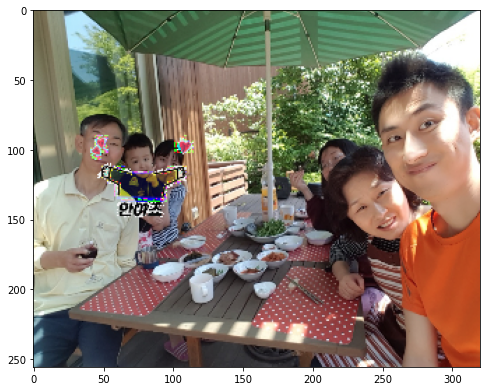

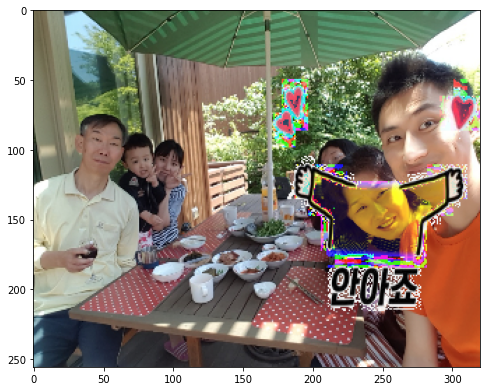

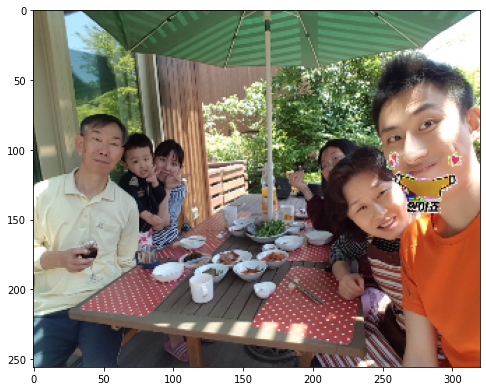

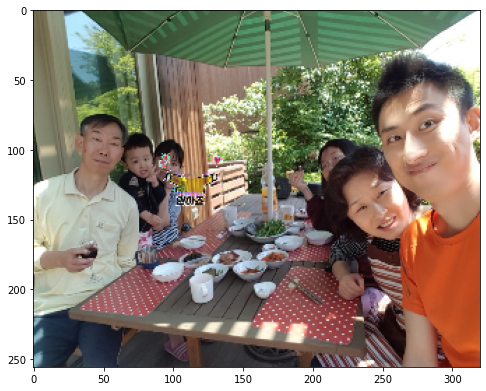

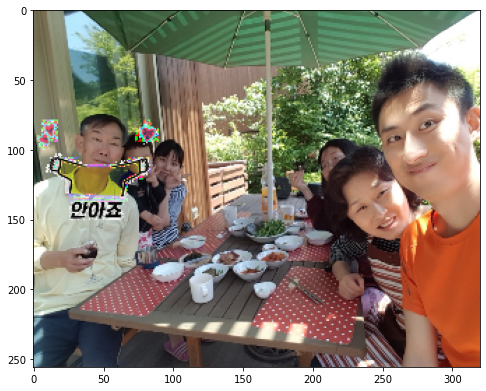

In [76]:
# 확인
for img in img_list:
    plt.figure(figsize=(8,8))
    plt.imshow(img)
    plt.show()

> **note**:
> - 위의 과정을 통해 현재 맞닥뜨린 부분을 설명하자면,
> - 구현된 `attach_sticker()`는 object가 여러 개여도 한 번에 하나씩만 스티커를 붙일 수 있다.
> - 그렇기에 스티커가 전부 다 붙어 있는 이미지가 return 되려면 for loop으로 구현할 때 쓰였던 이미지에 `attach_sticker()` 함수를 적용하는 방식으로 구현되어야 한다.
> - 그리고 이를 위해선 어떤 bbox에 맞게 어떤 스티커를 **먼저** 붙여야 하는지도 결정해놓아야 한다.
>   - 예를 들어 얼굴이 다닥다닥 붙어 있는 상태에서 양 옆으로 삐져나오는 스티커를 붙인다면 object 중 1개는 반드시 본인의 스티커 위를 다른 object의 스티커가 덮어씌우게 될 것이다.)

> **note**:
> - 그런데 적용된 스티커의 **색깔**이 이상하길래 확인해보려 한다.
> - 아마도 `np.where()` 컨디션에서 `sticker_img >= 245`로 해준 부분 때문에 진한 색깔들은 masking 된 것 같은데, 혹시나 Alpha 채널 값을 통해 분류해낼 수 있을지 확인해봐야겠다.

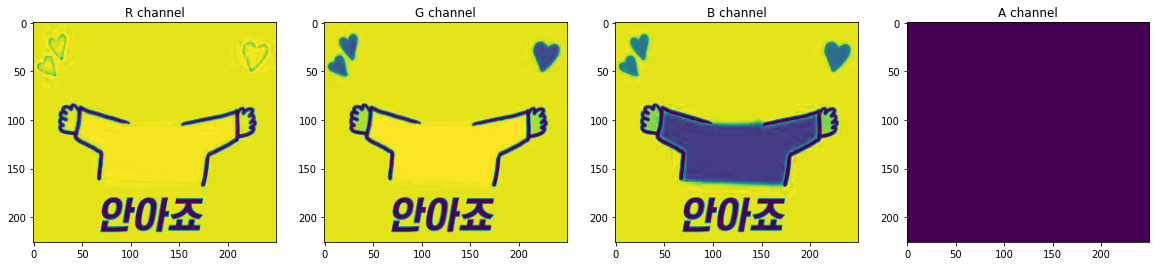

In [77]:
plt.figure(figsize=(20, 5))

plt.subplot(1, 4, 1)
plt.imshow(sticker_resized_copy[:, :, 0])
plt.title('R channel')

plt.subplot(1, 4, 2)
plt.imshow(sticker_resized_copy[:, :, 1])
plt.title('G channel')

plt.subplot(1, 4, 3)
plt.imshow(sticker_resized_copy[:, :, 2])
plt.title('B channel')

plt.subplot(1, 4, 4)
plt.imshow(sticker_resized_copy[:, :, 3])
plt.title('A channel')

plt.show()

In [78]:
# 첫번째 채널(R)에 있는 값들 확인
# 바탕의 하얀색이 대부분 255가 아니라 245로 되어 있다.
sticker_resized_copy[:, :, 0]

array([[245, 245, 245, ..., 245, 245, 245],
       [245, 245, 245, ..., 245, 245, 245],
       [245, 245, 245, ..., 245, 245, 245],
       ...,
       [245, 245, 245, ..., 245, 245, 245],
       [245, 245, 245, ..., 245, 245, 245],
       [245, 245, 245, ..., 245, 245, 245]], dtype=uint8)

> **note**:
> - Alpha channel 값으로 masking 하려 했더니, alpha channel 값은 전부 다 255여서 사용하기 불가능하다...
> - 그리고 다른 3채널에서 ` == 255`로 boolean indexing을 하는 것도 안되는 게, 보면 배경 값이 전부 245이다. 그래서 `== 255`로 하면 배경이 masking되지 않고, ` >= 245`로 해놓으면 위와 같이 진한 색깔이 있는 부분은 masking이 되어버린다.(예 : 하트)
> - 스티커를 일단 이걸 사용하고자 했으니, 이 부분은 감안하고 다음 단계로 넘어가겠다.

#### `attach_sticker()`함수를 통해 한 이미지 내 여러 스티커를 붙이는 함수 구현
- 먼저 `sort_by_area()` 함수를 만들어서 스티커를 붙일 순서로 bbox들을 정렬하고자 한다.
- 여기서 정렬 기준은 bbox 좌표 값을 토대로 했을 때 나오는 면적의 오름차순이다.

In [79]:
def sort_by_area(pred_boxes):
    w = pred_boxes[:, 2] - pred_boxes[:, 0]
    h = pred_boxes[:, 3] - pred_boxes[:, 1]
    area_array = w * h                                               # 면적 구하기
    pred_boxes = [pred_boxes[i, :] for i in np.argsort(area_array)]  # 면적 오름차순으로 box좌표들 정렬
    pred_boxes = np.array(pred_boxes)                                # 다시 ndarray화
    return pred_boxes

In [80]:
# 하나의 함수로 엮기
def attach_multiple_stickers(path, model, input_width, input_height, sticker_img, pred_boxes, h_offset_up, h_bbox, h_offset_down, w_offset_left, w_bbox, w_offset_right, bbox_ver=False):
    img_raw = cv2.imread(path)
    # assert img_raw.shape[-1] == sticker_img.shape[-1], f"images shape do not match. img_raw has {img_raw.shape[-1]} channels, but sticker_img has {sticker_img.shape[-1]} channels"
    original_height = img_raw.shape[0]
    original_width = img_raw.shape[1]
    img_raw_resized = cv2.resize(img_raw, (input_width, input_height))
    img = np.float32(img_raw_resized.copy())

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img, pad_params = pad_input_image(img, max_steps=max(BOX_STEPS))
    img = img / 255.0

    boxes = default_box()
    boxes = tf.cast(boxes, tf.float32)

    predictions = model.predict(img[np.newaxis, ...])

    pred_boxes, labels, scores = parse_predict(predictions, boxes)
    pred_boxes = recover_pad(pred_boxes, pad_params)
    pred_boxes = sort_by_area(pred_boxes)

    for box_index in range(len(pred_boxes)):
        img = attach_sticker(img, sticker_img, pred_boxes, box_index, h_offset_up, h_bbox, h_offset_down, w_offset_left, w_bbox, w_offset_right)
    img = cv2.resize(img, (original_width, original_height))
    if bbox_ver:
        bbox_img = img_raw_resized.copy()
        for box_index in range(len(pred_boxes)):
            draw_box_on_face(bbox_img, pred_boxes, labels, scores, box_index, IMAGE_LABELS)
        bbox_img = cv2.cvtColor(bbox_img, cv2.COLOR_BGR2RGB)
        bbox_img = cv2.resize(bbox_img, (original_width, original_height))
        return img, bbox_img
    
    return img

#### multiple 스티커 붙이기 실행

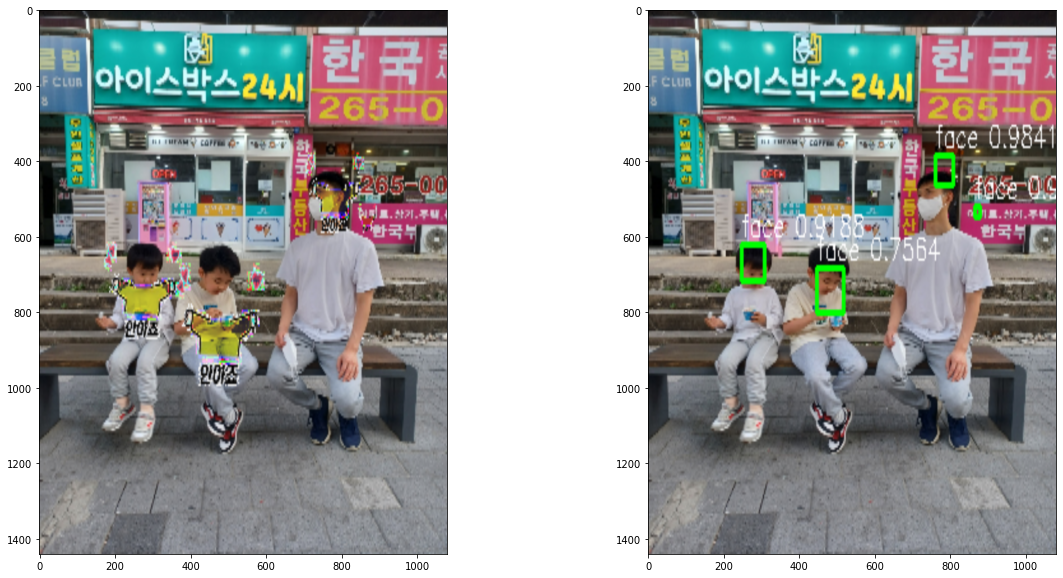

In [81]:
path_1 = '/content/drive/My Drive/Aiffel/GD_14/icecream_lovers.png'
result_1, bbox_1 = attach_multiple_stickers(path_1, 
                                    model, 
                                    IMAGE_WIDTH, 
                                    IMAGE_HEIGHT, 
                                    sticker_resized_copy, 
                                    pred_boxes, 
                                    h_offset_up, 
                                    h_bbox, 
                                    h_offset_down, 
                                    w_offset_left, 
                                    w_bbox, 
                                    w_offset_right,
                                    bbox_ver=True)

plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.imshow(result_1)

plt.subplot(1, 2, 2)
plt.imshow(bbox_1)
plt.show()

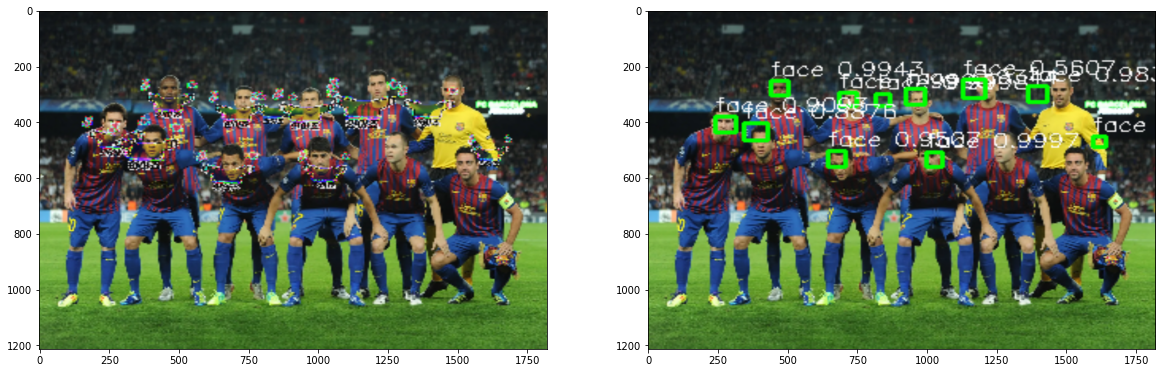

In [82]:
path_2 = os.path.join(ROOT_PATH, 'barca.png')

result_2, bbox_2 = attach_multiple_stickers(path_2, 
                                    model, 
                                    IMAGE_WIDTH, 
                                    IMAGE_HEIGHT, 
                                    sticker_resized_copy, 
                                    pred_boxes, 
                                    h_offset_up, 
                                    h_bbox, 
                                    h_offset_down, 
                                    w_offset_left, 
                                    w_bbox, 
                                    w_offset_right,
                                    bbox_ver=True)

plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.imshow(result_2)

plt.subplot(1, 2, 2)
plt.imshow(bbox_2)
plt.show()

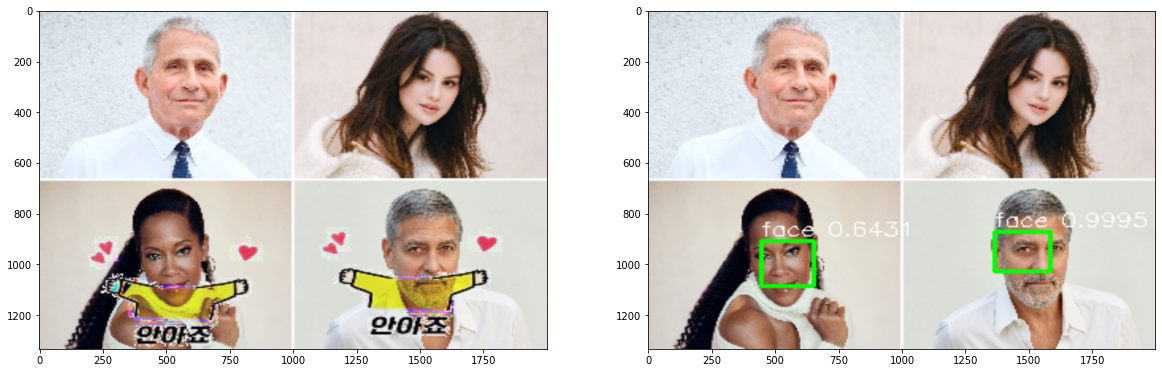

In [83]:
path_3 = os.path.join(ROOT_PATH, 'celeb.png')

result_3, bbox_3 = attach_multiple_stickers(path_3, 
                                    model, 
                                    IMAGE_WIDTH, 
                                    IMAGE_HEIGHT, 
                                    sticker_resized_copy, 
                                    pred_boxes, 
                                    h_offset_up, 
                                    h_bbox, 
                                    h_offset_down, 
                                    w_offset_left, 
                                    w_bbox, 
                                    w_offset_right,
                                    bbox_ver=True)

plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.imshow(result_3)

plt.subplot(1, 2, 2)
plt.imshow(bbox_3)
plt.show()

> **note**:
> - 추후 진짜 서비스 같이 만든다면, `h_offset_up`, ..., `w_offset_down` 부분은 입력되는 스티커 크기에 맞게 알아서 구해지고, 또 스티커 생성 함수에 들어가도록 짜놓으면 사용자 입장에서는 편리할 것 같다.